In [1]:
import rpy2.robjects as robjects
import numpy as np
import os as os
from rpy2.robjects import numpy2ri
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2
# Specify the path to your data files
data_path = "/Users/sarahurbut/Dropbox/aou_fromdl/"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
Y = np.array(robjects.r['readRDS'](os.path.join(data_path, 'Y_binary.rds')))
E = np.array(robjects.r['readRDS'](os.path.join(data_path, 'E_binary.rds')))
E = E.astype(int)


In [3]:

# Convert to PyTorch tensors
Y_tensor = torch.FloatTensor(Y)
E_tensor = torch.FloatTensor(E)


In [4]:
# Get dimensions
N, D, T = Y_tensor.shape
T = int(E_tensor.max() + 1)  # 0-indexed time
K = 20  # number of topics


In [5]:
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()
# Load the metadata from R
disease_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox/aou_fromdl/diagnames.rds'))
disease_names = disease_names[0].tolist()

In [6]:
# Print shapes to verify
print("Tensor shapes:")
print(f"Y: {Y_tensor.shape}")  # [N, D]
print(f"E: {E_tensor.shape}")  # [N, D]
print(f"Time range: 0 to {T-1}")
print(T)
print(K)


Tensor shapes:
Y: torch.Size([10000, 348, 51])
E: torch.Size([10000, 348])
Time range: 0 to 50
51
20


In [7]:
E_tensor 

tensor([[50., 50., 50.,  ..., 50., 50., 17.],
        [50., 50., 50.,  ..., 50., 50., 50.],
        [50., 50., 50.,  ..., 50., 50., 50.],
        ...,
        [50., 50., 50.,  ..., 50., 50., 50.],
        [50., 50., 50.,  ..., 50., 50., 50.],
        [50., 50., 50.,  ..., 50., 50., 41.]])

In [8]:
from cluster_g_logit_init import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

In [9]:
Y = torch.tensor(Y, dtype=torch.float32)
prevalence_t=compute_smoothed_prevalence(Y=Y,window_size=5)


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_90278/1352526393.py:196: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()



Cluster Memberships:

Cluster 0 (4 diseases):
  - Breast cancer [female]
  - Malignant neoplasm of female breast
  - Benign neoplasm of breast
  - Lump or mass in breast

Cluster 1 (38 diseases):
  - Gram negative septicemia
  - Bacterial infection NOS
  - Staphylococcus infections
  - Streptococcus infection
  - E. coli
  - Hypoglycemia
  - Disorders of calcium/phosphorus metabolism
  - Hyposmolality and/or hyponatremia
  - Hypopotassemia
  - Acidosis
  - Hypovolemia
  - Other anemias
  - Thrombocytopenia
  - Bipolar
  - Major depressive disorder
  - Anxiety disorder
  - Alcohol-related disorders
  - Alcoholic liver damage
  - Tobacco use disorder
  - Epilepsy, recurrent seizures, convulsions
  - Inflammatory and toxic neuropathy
  - Other acute and subacute forms of ischemic heart disease
  - Hypotension NOS
  - Dental caries
  - Periapical abscess
  - Other diseases of the teeth and supporting structures
  - Constipation
  - Other chronic nonalcoholic liver disease
  - Other disord

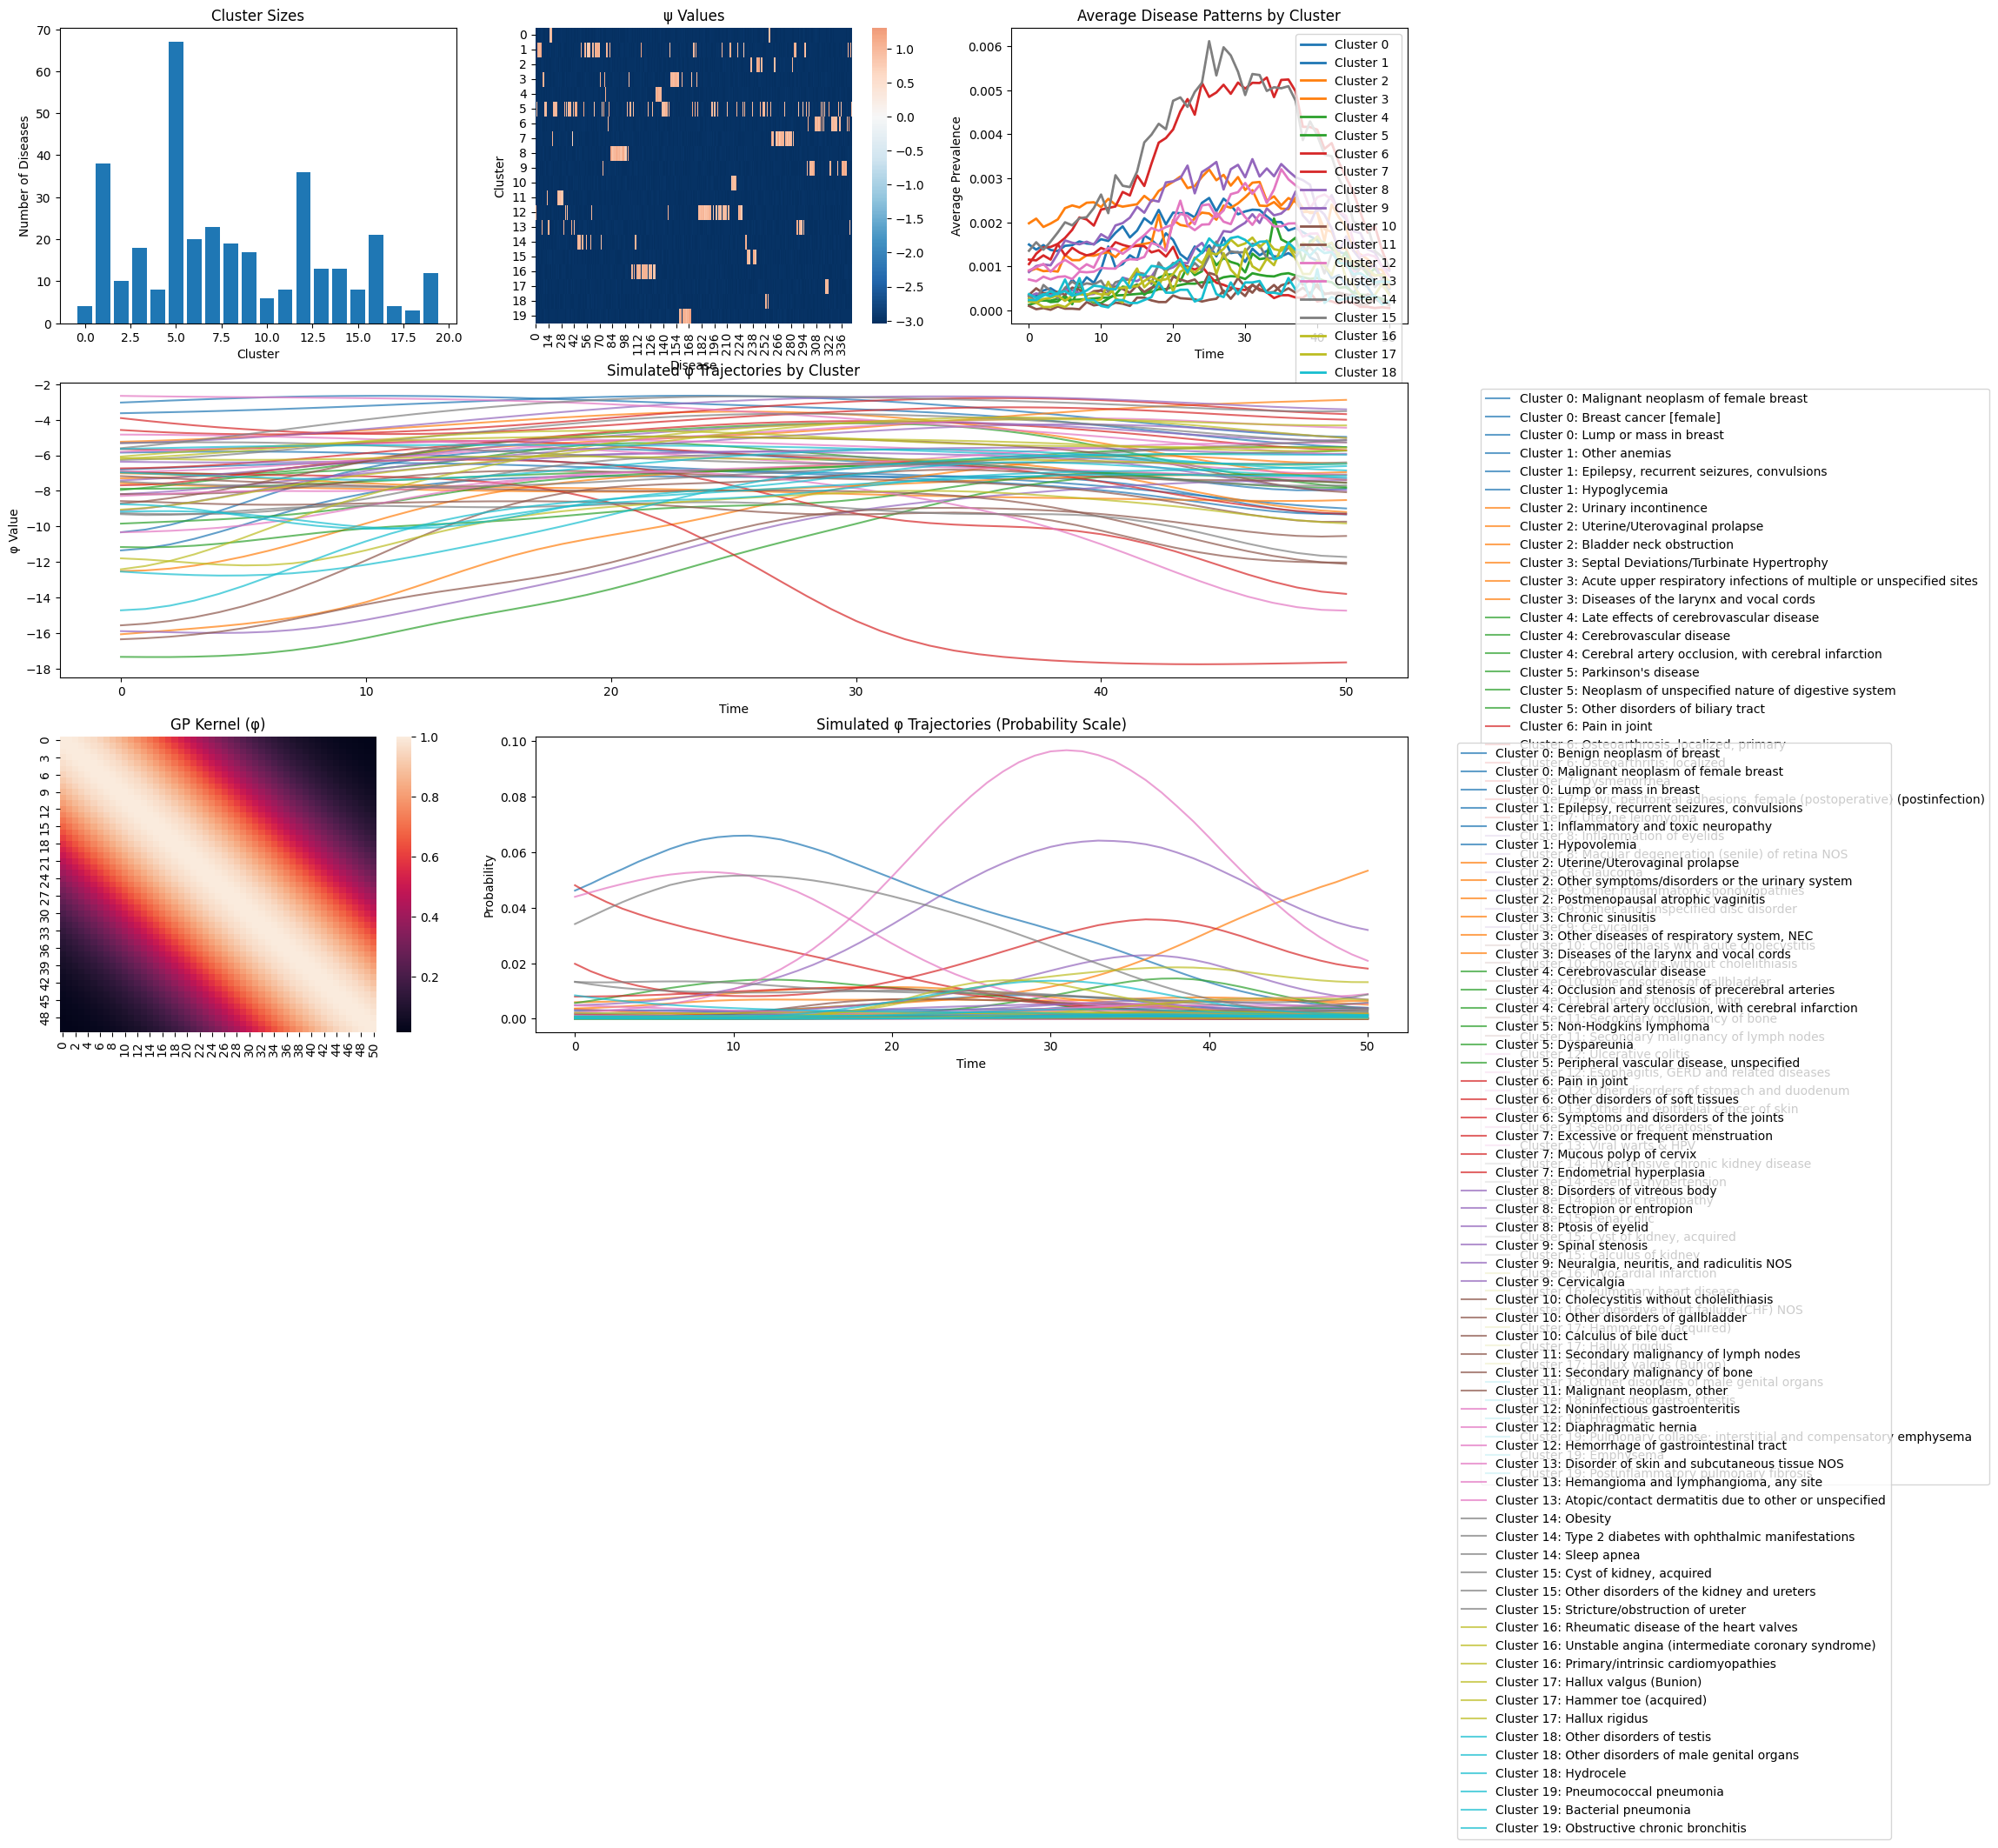

In [10]:
prevalence_t=compute_smoothed_prevalence(Y=Y,window_size=5)
prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
epsilon = 1e-8
logit_prev_t = torch.log((prevalence_t + epsilon) / (1 - prevalence_t + epsilon))

K=20
# Create model
def initialize_disease_clusters(Y, K, T, logit_prev_t, disease_names=None, random_state=42):
    """
    Initialize disease clusters and simulate phi trajectories using GP prior
    
    Parameters:
    Y: numpy array (N x D x T) of disease trajectories
    K: int, number of clusters
    T: int, number of time points
    logit_prev_t: tensor (D x T) of logit prevalence trajectories
    disease_names: list of disease names (optional)
    random_state: int, random seed for reproducibility
    """
    # Convert inputs to torch tensors if needed
    if not isinstance(Y, torch.Tensor):
        Y = torch.tensor(Y, dtype=torch.float32)
    if not isinstance(logit_prev_t, torch.Tensor):
        logit_prev_t = torch.tensor(logit_prev_t, dtype=torch.float32)
    
    N, D, T = Y.shape
    
    # Set kernel parameters as in the model
    lambda_length_scale = T/4
    phi_length_scale = T/3
    amplitude = 1.0
    
    # Compute kernel matrices
    times = torch.arange(T, dtype=torch.float32)
    sq_dists = (times.unsqueeze(0) - times.unsqueeze(1)) ** 2
    K_phi = amplitude ** 2 * torch.exp(-0.5 * sq_dists / (phi_length_scale ** 2))
    jitter = 1e-6
    K_phi = K_phi + jitter * torch.eye(T)
    
    # Perform clustering as before
    Y_avg = torch.mean(Y, dim=2)
    epsilon = 1e-8
    Y_avg = torch.log((Y_avg + epsilon)/(1-Y_avg+epsilon))
    
    Y_corr = torch.corrcoef(Y_avg.T)
    similarity = (Y_corr + 1) / 2
    
    spectral = SpectralClustering(
        n_clusters=K,
        assign_labels='kmeans',
        affinity='precomputed',
        n_init=10,
        random_state=random_state
    ).fit(similarity.numpy())
    
    clusters = spectral.labels_
    
    # Initialize psi
    psi = torch.zeros((K, D))
    for k in range(K):
        cluster_mask = (clusters == k)
        psi[k, cluster_mask] = 1.0 + 0.1 * torch.randn(cluster_mask.sum())
        psi[k, ~cluster_mask] = -3.0 + 0.01 * torch.randn((~cluster_mask).sum())
    
    # Simulate phi using GP prior
    L_phi = torch.linalg.cholesky(K_phi)
    phi = torch.zeros((K, D, T))
    
    for k in range(K):
        for d in range(D):
            mean_phi = logit_prev_t[d, :] + psi[k, d]
            eps = L_phi @ torch.randn(T)
            phi[k, d, :] = mean_phi + eps
    
    # Store cluster information
    cluster_info = {
        'sizes': {},
        'members': {},
        'avg_trajectories': {}
    }
    
    unique, counts = np.unique(clusters, return_counts=True)
    for k, count in zip(unique, counts):
        cluster_info['sizes'][k] = count.item()
        cluster_mask = (clusters == k)
        
        if disease_names is not None:
            members = [disease_names[i] for i in range(D) if cluster_mask[i]]
        else:
            members = [i for i in range(D) if cluster_mask[i]]
        
        cluster_info['members'][k] = members
        cluster_info['avg_trajectories'][k] = Y_avg[:, cluster_mask].mean(dim=1)
    
    return {
        'clusters': clusters,
        'psi': psi,
        'phi': phi,
        'cluster_info': cluster_info,
        'K_phi': K_phi
    }




def plot_cluster_results(cluster_results, Y, disease_names=None, n_example_trajectories=3):
    """
    Visualize clustering results including simulated phi trajectories
    """
    K = cluster_results['psi'].shape[0]
    D = Y.shape[1]
    T = Y.shape[2]
    
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(3, 3)
    
    # Plot 1: Cluster sizes
    ax1 = fig.add_subplot(gs[0, 0])
    sizes = list(cluster_results['cluster_info']['sizes'].values())
    ax1.bar(range(K), sizes)
    ax1.set_title('Cluster Sizes')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Number of Diseases')
    
    # Plot 2: Psi heatmap
    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(cluster_results['psi'].numpy(), 
                cmap='RdBu_r', 
                center=0,
                ax=ax2)
    ax2.set_title('ψ Values')
    ax2.set_xlabel('Disease')
    ax2.set_ylabel('Cluster')
    
    # Plot 3: Average temporal patterns
    ax3 = fig.add_subplot(gs[0, 2])
    Y_avg = torch.mean(Y, dim=0).numpy()
    clusters = cluster_results['clusters']
    colors = plt.cm.tab10(np.linspace(0, 1, K))
    
    for k in range(K):
        cluster_mask = (clusters == k)
        cluster_avg = Y_avg[cluster_mask].mean(axis=0)
        ax3.plot(cluster_avg, color=colors[k], label=f'Cluster {k}', linewidth=2)
    ax3.set_title('Average Disease Patterns by Cluster')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Average Prevalence')
    ax3.legend()
    
    # Plot 4: Simulated phi trajectories
    ax4 = fig.add_subplot(gs[1, :])
    phi = cluster_results['phi']
    
    for k in range(K):
        cluster_mask = (clusters == k)
        cluster_diseases = np.where(cluster_mask)[0]
        
        # Select random examples
        n_examples = min(n_example_trajectories, len(cluster_diseases))
        example_diseases = np.random.choice(cluster_diseases, n_examples, replace=False)
        
        for d in example_diseases:
            label = f'Cluster {k}: ' + (disease_names[d] if disease_names is not None else f'Disease {d}')
            ax4.plot(phi[k, d, :].numpy(), color=colors[k], alpha=0.7, label=label)
    
    ax4.set_title('Simulated φ Trajectories by Cluster')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('φ Value')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 5: GP kernel
    ax5 = fig.add_subplot(gs[2, 0])
    sns.heatmap(cluster_results['K_phi'].numpy(), ax=ax5)
    ax5.set_title('GP Kernel (φ)')
    
    # Plot transformed phi (probability scale)
    ax6 = fig.add_subplot(gs[2, 1:])
    phi_prob = torch.sigmoid(phi)
    
    for k in range(K):
        cluster_mask = (clusters == k)
        cluster_diseases = np.where(cluster_mask)[0]
        
        n_examples = min(n_example_trajectories, len(cluster_diseases))
        example_diseases = np.random.choice(cluster_diseases, n_examples, replace=False)
        
        for d in example_diseases:
            label = f'Cluster {k}: ' + (disease_names[d] if disease_names is not None else f'Disease {d}')
            ax6.plot(phi_prob[k, d, :].numpy(), color=colors[k], alpha=0.7, label=label)
    
    ax6.set_title('Simulated φ Trajectories (Probability Scale)')
    ax6.set_xlabel('Time')
    ax6.set_ylabel('Probability')
    ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Print cluster memberships
    print("\nCluster Memberships:")
    for k in range(K):
        print(f"\nCluster {k} ({cluster_results['cluster_info']['sizes'][k]} diseases):")
        members = cluster_results['cluster_info']['members'][k]
        if disease_names is not None:
            for member in members:
                print(f"  - {member}")
    
    plt.show()

# Example usage:

cluster_results = initialize_disease_clusters(
    Y=Y,
    K=20,
    T=T,
    logit_prev_t=logit_prev_t,
    disease_names=disease_names
)

plot_cluster_results(cluster_results, Y, disease_names)


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


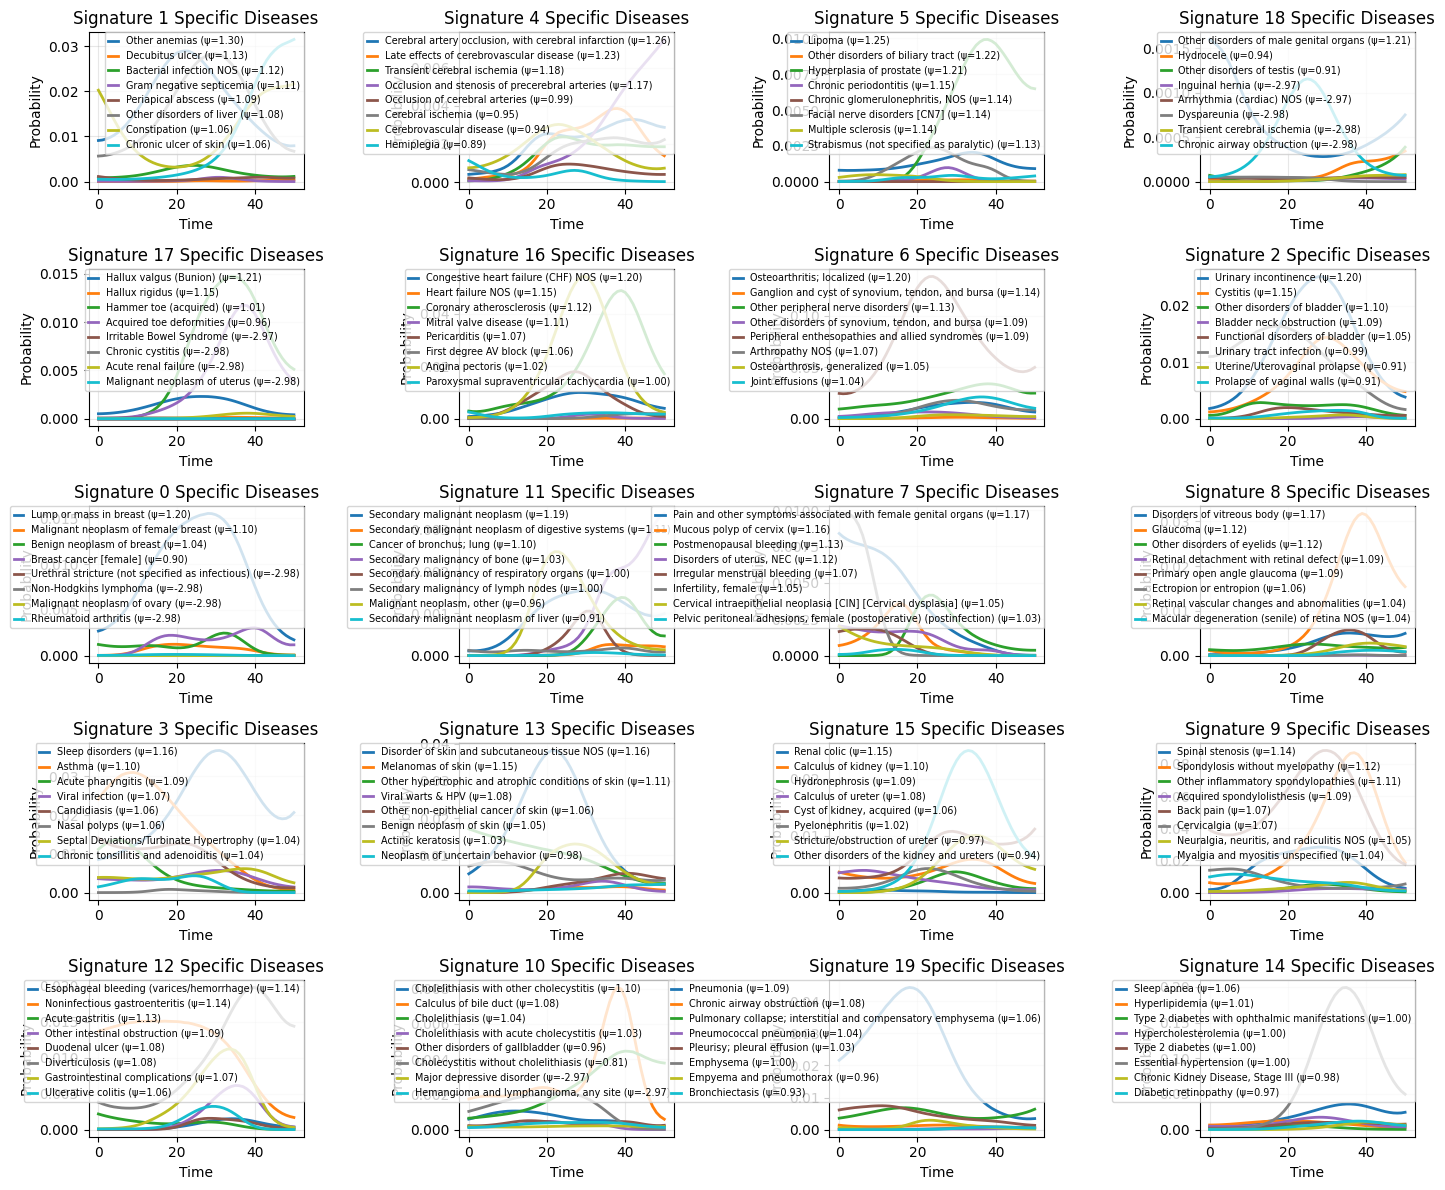

In [11]:
def plot_signature_trajectories(cluster_results, n_signatures=20, n_top_diseases=5, disease_names=None):
    """
    Plot phi trajectories for signature-specific diseases in selected clusters
    
    Parameters:
    cluster_results: output from initialize_disease_clusters
    n_signatures: number of signatures (clusters) to plot
    n_top_diseases: number of most signature-specific diseases to show per cluster
    disease_names: list of disease names (optional)
    """
    K = cluster_results['psi'].shape[0]
    phi = cluster_results['phi']
    psi = cluster_results['psi']
    
    # Select clusters with most distinct patterns (highest psi values)
    cluster_specificity = torch.max(psi, dim=1)[0]  # Maximum psi value per cluster
    top_clusters = torch.argsort(cluster_specificity, descending=True)[:n_signatures]
    
    # Create subplot grid
    fig, axes = plt.subplots(5, 4, figsize=(15, 12))
    axes = axes.flatten()
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_top_diseases))
    
    for idx, k in enumerate(top_clusters):
        ax = axes[idx]
        
        # Find most specific diseases for this signature
        psi_k = psi[k, :]
        top_diseases = torch.argsort(psi_k, descending=True)[:n_top_diseases]
        
        # Plot phi trajectories
        for i, d in enumerate(top_diseases):
            phi_trajectory = phi[k, d, :].numpy()
            prob_trajectory = torch.sigmoid(phi[k, d, :]).numpy()
            
            label = f"{disease_names[d] if disease_names is not None else f'Disease {d}'} (ψ={psi_k[d]:.2f})"
            
            # Plot on probability scale
            ax.plot(prob_trajectory, color=colors[i], linewidth=2, label=label)
        
        ax.set_title(f'Signature {k} Specific Diseases')
        ax.set_xlabel('Time')
        ax.set_ylabel('Probability')
        # Modify legend parameters to fit within each subplot
        ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),
                 fontsize='x-small',  # Make font smaller
                 framealpha=0.8,      # Make background slightly transparent
                 handlelength=1,      # Shorter lines in legend
                 borderaxespad=0.)    # Reduce padding
        ax.grid(True, alpha=0.3)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave some space on the right
    plt.show()

cluster_results = initialize_disease_clusters(
    Y=Y,
    K=20,
    T=T,
    logit_prev_t=logit_prev_t,
    disease_names=disease_names
)

plot_signature_trajectories(
    cluster_results,
    n_signatures=20,
    n_top_diseases=8,
    disease_names=disease_names
)


In [14]:
initial_clusters=cluster_results['clusters']


Empirical signature proportions:
Signature 0 (4 diseases):
  t=0:  0.005
  t=51: 0.003
Signature 1 (38 diseases):
  t=0:  0.221
  t=51: 0.111
Signature 2 (10 diseases):
  t=0:  0.035
  t=51: 0.036
Signature 3 (18 diseases):
  t=0:  0.138
  t=51: 0.056
Signature 4 (8 diseases):
  t=0:  0.004
  t=51: 0.030
Signature 5 (67 diseases):
  t=0:  0.053
  t=51: 0.082
Signature 6 (20 diseases):
  t=0:  0.082
  t=51: 0.112
Signature 7 (23 diseases):
  t=0:  0.103
  t=51: 0.007
Signature 8 (19 diseases):
  t=0:  0.023
  t=51: 0.076
Signature 9 (17 diseases):
  t=0:  0.058
  t=51: 0.091
Signature 10 (6 diseases):
  t=0:  0.008
  t=51: 0.004
Signature 11 (8 diseases):
  t=0:  0.003
  t=51: 0.010
Signature 12 (36 diseases):
  t=0:  0.098
  t=51: 0.086
Signature 13 (13 diseases):
  t=0:  0.046
  t=51: 0.060
Signature 14 (13 diseases):
  t=0:  0.068
  t=51: 0.078
Signature 15 (8 diseases):
  t=0:  0.010
  t=51: 0.018
Signature 16 (21 diseases):
  t=0:  0.022
  t=51: 0.082
Signature 17 (4 diseases):
  

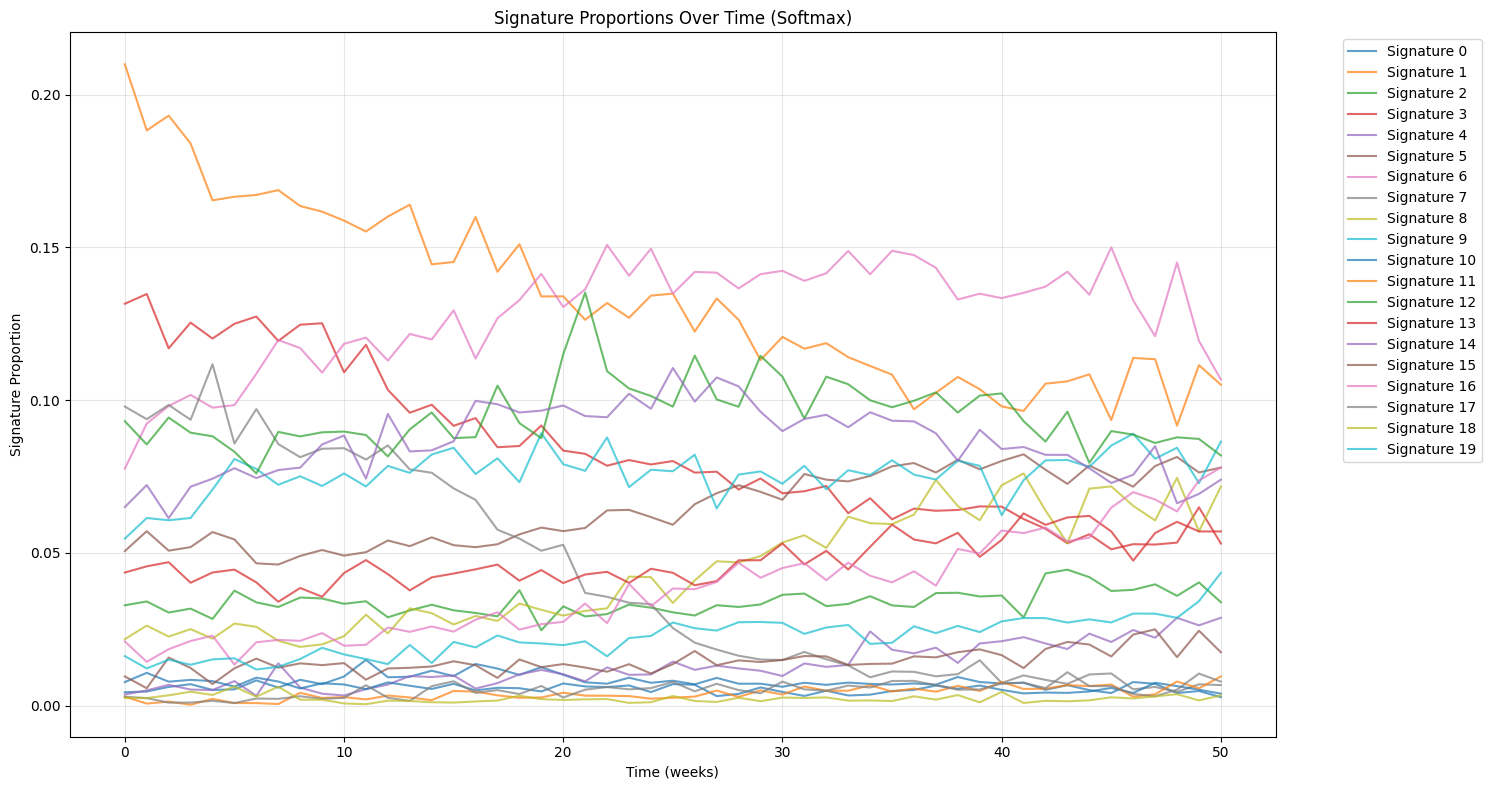


Signature proportion ranges:
Signature 0: 0.048 - 0.048
Signature 1: 0.052 - 0.059
Signature 2: 0.049 - 0.050
Signature 3: 0.050 - 0.054
Signature 4: 0.048 - 0.049
Signature 5: 0.050 - 0.052
Signature 6: 0.051 - 0.055
Signature 7: 0.048 - 0.053
Signature 8: 0.049 - 0.051
Signature 9: 0.050 - 0.052
Signature 10: 0.048 - 0.048
Signature 11: 0.048 - 0.048
Signature 12: 0.051 - 0.055
Signature 13: 0.049 - 0.051
Signature 14: 0.051 - 0.053
Signature 15: 0.048 - 0.049
Signature 16: 0.048 - 0.052
Signature 17: 0.048 - 0.048
Signature 18: 0.048 - 0.048
Signature 19: 0.048 - 0.050


In [15]:

# Calculate signature proportions through time
Y_counts = Y.sum(dim=0)  # Sum over individuals: D x T
signature_props = torch.zeros(20, T)  # (K=20 signatures, T=51 timepoints)

for k in range(20):
    cluster_mask = (initial_clusters == k)
    signature_props[k] = Y_counts[cluster_mask].sum(dim=0) / Y_counts.sum(dim=0)

# Print proportions at first and last timepoint
print("\nEmpirical signature proportions:")
for k in range(20):
    cluster_size = (initial_clusters == k).sum()
    print(f"Signature {k} ({cluster_size} diseases):")
    print(f"  t=0:  {signature_props[k,0]:.3f}")
    print(f"  t=51: {signature_props[k,-1]:.3f}")

# Add healthy proportion and rescale
healthy_prop = 0.05
signature_props = signature_props * (1 - healthy_prop)

import matplotlib.pyplot as plt

# Convert to softmax proportions
def softmax(x):
    exp_x = torch.exp(x - torch.max(x, dim=0)[0])
    return exp_x / exp_x.sum(dim=0)

# Calculate softmax proportions
softmax_props = softmax(signature_props)

# Plot
plt.figure(figsize=(15, 8))
timepoints = range(T)

# Plot each signature
for k in range(20):
    plt.plot(timepoints, signature_props[k], label=f'Signature {k}', alpha=0.7)

plt.xlabel('Time (weeks)')
plt.ylabel('Signature Proportion')
plt.title('Signature Proportions Over Time (Softmax)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print some summary stats
print("\nSignature proportion ranges:")
for k in range(20):
    min_prop = softmax_props[k].min().item()
    max_prop = softmax_props[k].max().item()
    print(f"Signature {k}: {min_prop:.3f} - {max_prop:.3f}")



/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_90278/408032137.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  healthy_ref = torch.ones(T) * logit(torch.tensor(healthy_prop))


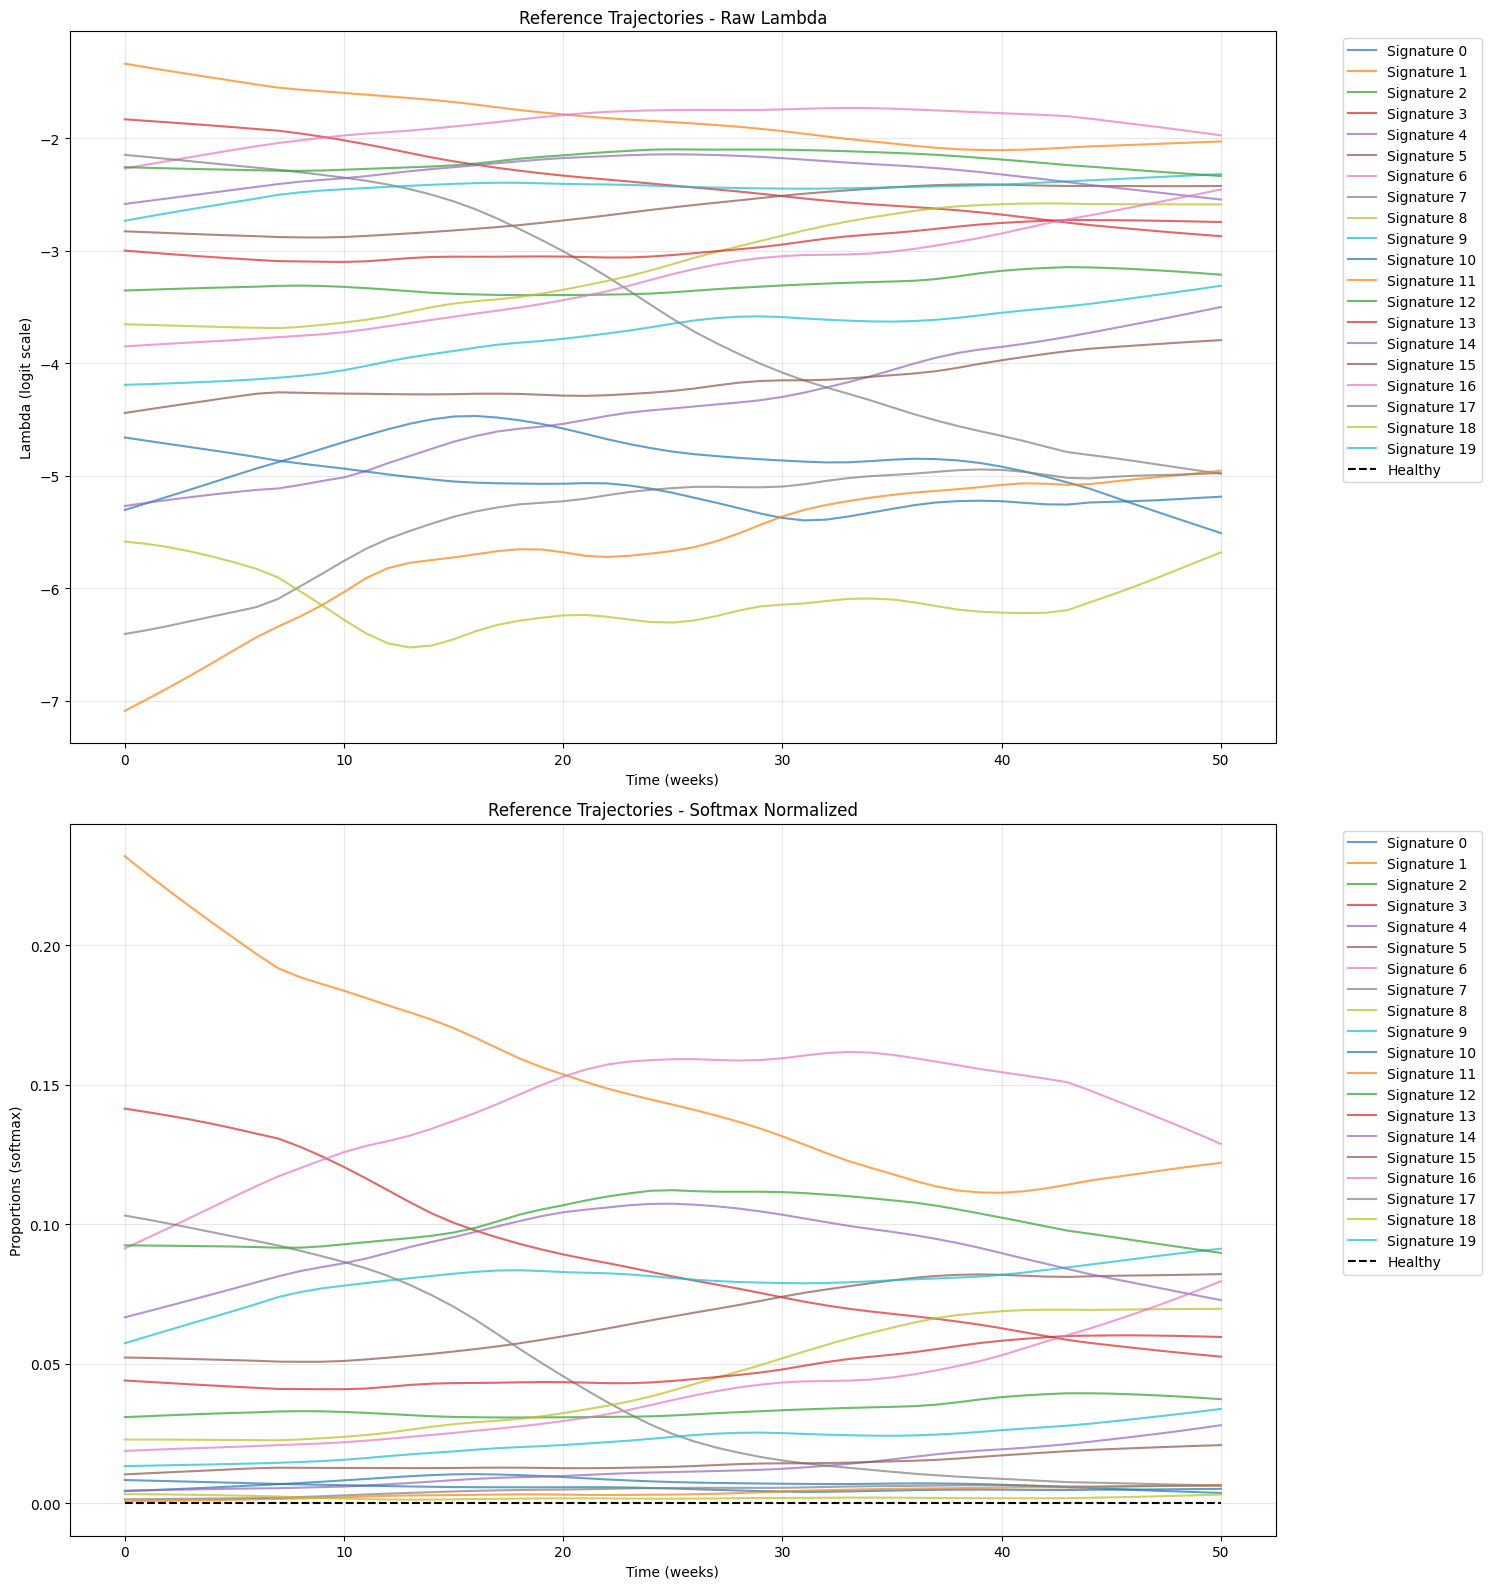

In [16]:
def create_reference_trajectories(Y_filtered, initial_clusters, K, healthy_prop=0, frac=0.3):
    """Create reference trajectories using LOWESS smoothing on logit scale"""
    from statsmodels.nonparametric.smoothers_lowess import lowess
    from scipy.special import logit
    T = Y.shape[2]
    
    # Get raw counts and proportions
    Y_counts = Y.sum(dim=0)  
    signature_props = torch.zeros(K, T)
    total_counts = Y_counts.sum(dim=0) + 1e-8
    
    for k in range(K):
        cluster_mask = (initial_clusters == k)
        signature_props[k] = Y_counts[cluster_mask].sum(dim=0) / total_counts
    
    # Normalize and clamp
    signature_props = torch.clamp(signature_props, min=1e-8, max=1-1e-8)
    signature_props = signature_props / signature_props.sum(dim=0, keepdim=True)
    signature_props *= (1 - healthy_prop)
    
    # Convert to logit and smooth
    logit_props = torch.tensor(logit(signature_props.numpy()))
    signature_refs = torch.zeros_like(logit_props)
    
    times = np.arange(T)
    for k in range(K):
        smoothed = lowess(
            logit_props[k].numpy(), 
            times,
            frac=frac,
            it=3,
            delta=0.0,
            return_sorted=False
        )
        signature_refs[k] = torch.tensor(smoothed)
    
    healthy_ref = torch.ones(T) * logit(torch.tensor(healthy_prop))
    
    return signature_refs, healthy_ref

# Create trajectories
signature_refs, healthy_ref = create_reference_trajectories(Y, initial_clusters, K=20)

# Plot both versions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))

# Plot 1: Raw smoothed lambda (logit scale)
for k in range(20):
    ax1.plot(range(T), signature_refs[k], label=f'Signature {k}', alpha=0.7)
ax1.plot(range(T), healthy_ref, label='Healthy', color='black', linestyle='--')
ax1.set_xlabel('Time (weeks)')
ax1.set_ylabel('Lambda (logit scale)')
ax1.set_title('Reference Trajectories - Raw Lambda')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Softmax normalized
props = torch.softmax(torch.vstack([signature_refs, healthy_ref]), dim=0)
for k in range(20):
    ax2.plot(range(T), props[k], label=f'Signature {k}', alpha=0.7)
ax2.plot(range(T), props[-1], label='Healthy', color='black', linestyle='--')
ax2.set_xlabel('Time (weeks)')
ax2.set_ylabel('Proportions (softmax)')
ax2.set_title('Reference Trajectories - Softmax Normalized')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
Y = torch.tensor(Y, dtype=torch.float32)
prevalence_t=compute_smoothed_prevalence(Y=Y,window_size=5)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_90278/808097325.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


In [18]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')  # Update with your actual path
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
signature_refs

tensor([[-5.3034, -5.2430, -5.1824,  ..., -5.3795, -5.4440, -5.5086],
        [-1.3363, -1.3687, -1.4002,  ..., -2.0422, -2.0347, -2.0276],
        [-3.3523, -3.3461, -3.3398,  ..., -3.1839, -3.1973, -3.2117],
        ...,
        [-6.4050, -6.3723, -6.3332,  ..., -4.9893, -4.9839, -4.9747],
        [-5.5843, -5.6046, -5.6343,  ..., -5.8362, -5.7578, -5.6803],
        [-4.1908, -4.1849, -4.1781,  ..., -3.3665, -3.3390, -3.3102]])

In [20]:
torch.save(signature_refs, 'signature_refs_aou.pt')

In [39]:
Y_tensor

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [52]:
signature_refs.shape

torch.Size([20, 51])

In [53]:
Y.shape

torch.Size([10000, 348, 51])

In [61]:
# After loading your AOU data
N, D, T = Y_tensor.shape
K = 20  # number of topics

# Create dummy genetics with one feature per patient
dummy_G = torch.randn((N, 2))


# Initialize the model
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=N, 
    D=D, 
    T=T, 
    K=K,
    P=2,  # Dummy feature dimension
    init_sd_scaler=1e-1,
    G=dummy_G, 
    Y=Y_tensor,
    genetic_scale=0,  # Disable genetic effects
    W=0.0001,
    R=0,
    prevalence_t=prevalence_t,
    signature_references=signature_refs,  # Or your reference if available
    healthy_reference=True,
    disease_names=disease_names
)

model.initialize_params(true_psi=cluster_results['psi'])
model.clusters = cluster_results['clusters']

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts


Cluster Sizes:
Cluster 0: 4 diseases
Cluster 1: 38 diseases
Cluster 2: 10 diseases
Cluster 3: 18 diseases
Cluster 4: 8 diseases
Cluster 5: 67 diseases
Cluster 6: 20 diseases
Cluster 7: 23 diseases
Cluster 8: 19 diseases
Cluster 9: 17 diseases
Cluster 10: 6 diseases
Cluster 11: 8 diseases
Cluster 12: 36 diseases
Cluster 13: 13 diseases
Cluster 14: 13 diseases
Cluster 15: 8 diseases
Cluster 16: 21 diseases
Cluster 17: 4 diseases
Cluster 18: 3 diseases
Cluster 19: 12 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 4
Base value (first 5): tensor([-18.4207, -18.4207, -18.4207, -18.4207, -18.4207])
Base value centered (first 5): tensor([-0.7439, -0.7439, -0.7439, -0.7439, -0.7439])
Base value centered mean: 2.595138539618347e-06
Gamma init for k=0 (first 5): tensor([0.0061, 0.0197])

Calculating gamma for k=1:
Number of diseases in cluster: 38
Base value (first 5): tensor([-13.8390, -18.4207, -17.6571, -17.2753, -17.6571])
Base value centered (first 5): tensor([ 3.3035, 

In [62]:
clusters_match = np.array_equal(clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")


Clusters match exactly: True


In [63]:
model.phi

Parameter containing:
tensor([[[-11.0928, -11.0923, -11.0910,  ..., -12.1390, -12.1835, -12.2027],
         [-11.1467, -11.1580, -11.1685,  ..., -13.8761, -14.0154, -14.0845],
         [-14.0620, -14.1074, -14.1916,  ..., -13.4032, -13.4907, -13.5362],
         ...,
         [ -8.7790,  -8.7740,  -8.7627,  ...,  -9.4850,  -9.5199,  -9.5337],
         [-10.1033, -10.1053, -10.1077,  ..., -10.3915, -10.4207, -10.4370],
         [ -8.5942,  -8.5978,  -8.6047,  ...,  -9.5111,  -9.5441,  -9.5571]],

        [[-10.9703, -10.9689, -10.9656,  ..., -12.0220, -12.0715, -12.0950],
         [-10.9449, -10.9444, -10.9429,  ..., -13.9163, -14.0738, -14.1623],
         [ -9.9265,  -9.9737, -10.0607,  ...,  -9.4784,  -9.5774,  -9.6332],
         ...,
         [ -8.8096,  -8.8087,  -8.8025,  ...,  -9.3215,  -9.3681,  -9.3919],
         [ -6.4514,  -6.4481,  -6.4455,  ...,  -6.2573,  -6.2838,  -6.2956],
         [ -8.6374,  -8.6393,  -8.6451,  ...,  -9.6990,  -9.7300,  -9.7441]],

        [[-11.0332, -1

In [64]:
print(model.K_total)
print(model.K)
print(model.lrtpen)
print(model.gpweight)
print(model.lambda_amplitude)

21
20
0
0.0001
1


/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:541: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


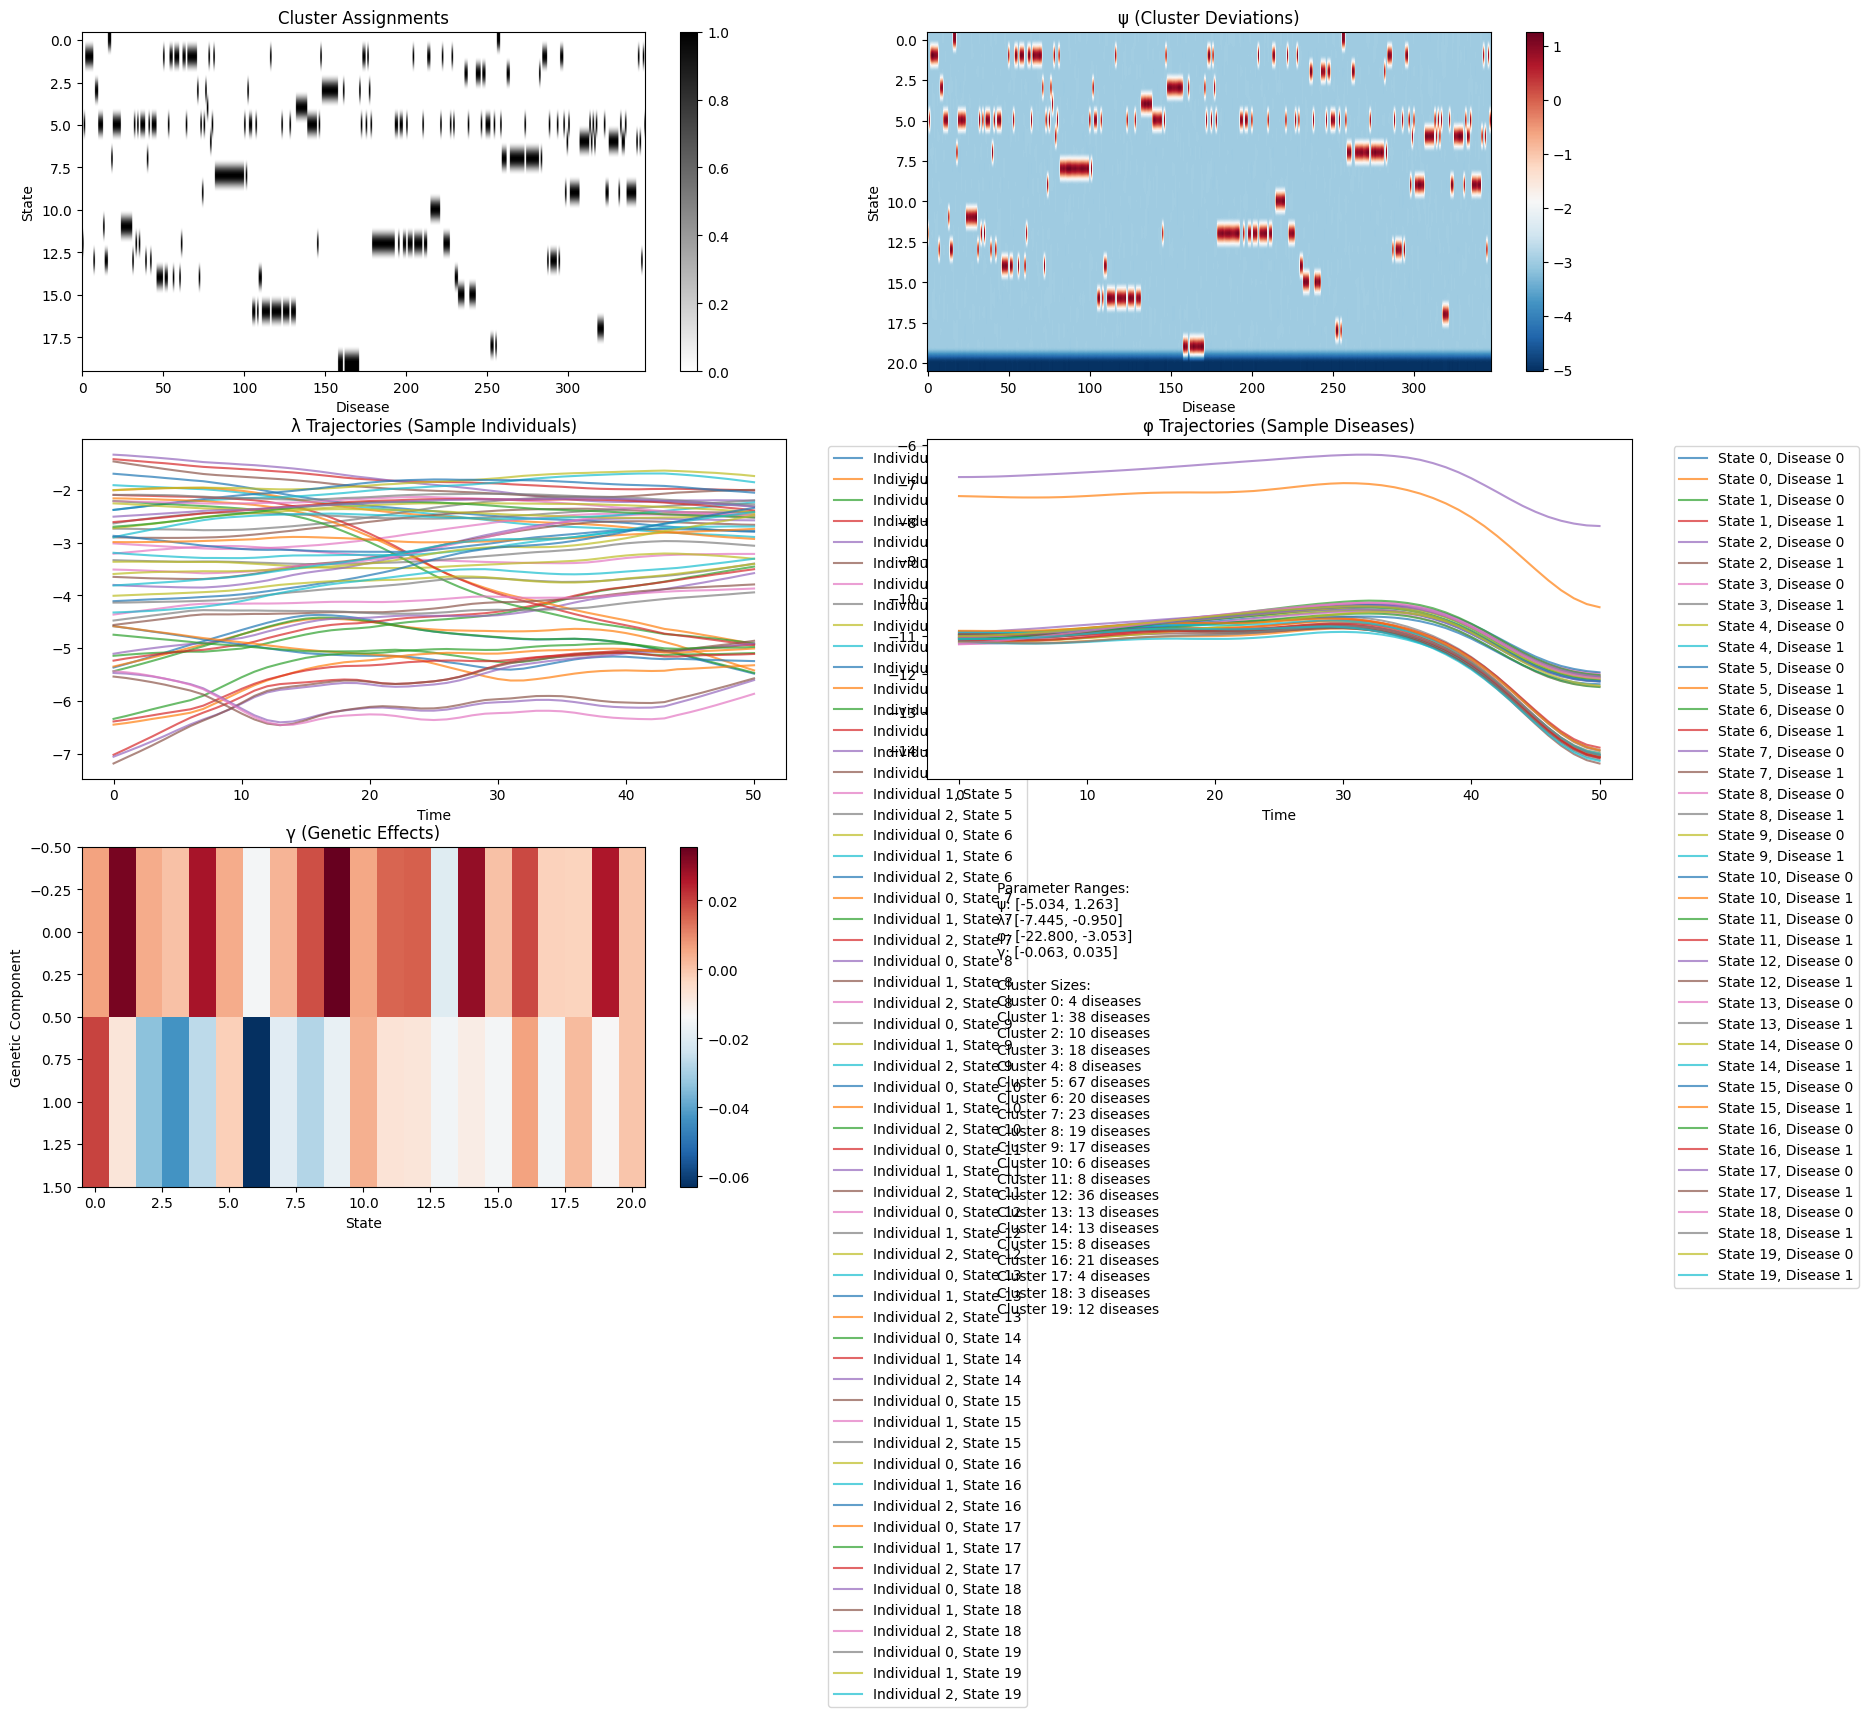

In [65]:
model.visualize_initialization()

In [67]:
initial_gamma = model.gamma.detach().clone()
initial_phi = model.phi.detach().clone()
initial_lambda = model.lambda_.detach().clone()
initial_psi = model.psi.detach().clone()



In [69]:
import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model.fit(E_tensor, num_epochs=200, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)
        

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


Kappa gradient: -1.871e+01

Epoch 0
Loss: 189.1581

Monitoring signature responses:

Disease 65 (signature 1, LR=80.49):
  Theta for diagnosed: 0.150 ± 0.039
  Theta for others: 0.149
  Proportion difference: 0.001

Disease 78 (signature 1, LR=77.59):
  Theta for diagnosed: 0.149 ± 0.039
  Theta for others: 0.149
  Proportion difference: 0.000

Disease 31 (signature 13, LR=76.48):
  Theta for diagnosed: 0.049 ± 0.010
  Theta for others: 0.048
  Proportion difference: 0.000

Disease 140 (signature 5, LR=76.06):
  Theta for diagnosed: 0.067 ± 0.016
  Theta for others: 0.067
  Proportion difference: 0.000

Disease 84 (signature 8, LR=75.69):
  Theta for diagnosed: 0.045 ± 0.020
  Theta for others: 0.045
  Proportion difference: 0.000
Kappa gradient: -1.643e+01

Epoch 1
Loss: 806.2907

Monitoring signature responses:

Disease 65 (signature 1, LR=80.88):
  Theta for diagnosed: 0.150 ± 0.038
  Theta for others: 0.150
  Proportion difference: 0.000

Disease 78 (signature 1, LR=77.89):
  Theta

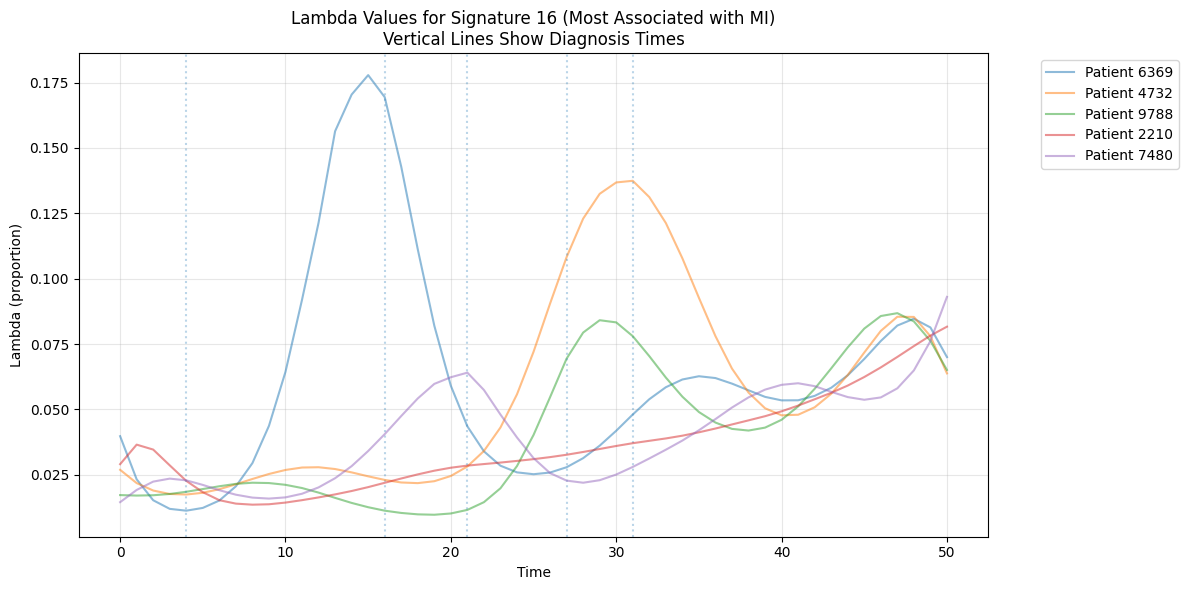

In [70]:
def plot_disease_lambda_alignment(model):
    """
    Plot lambda values aligned with disease occurrences for selected patients
    """
    # Find patients with specific diseases and their diagnosis times
    disease_idx = 112  # MI
    patients_with_disease = []
    diagnosis_times = []
    
    for patient in range(model.Y.shape[0]):
        diag_time = torch.where(model.Y[patient, disease_idx])[0]
        if len(diag_time) > 0:
            patients_with_disease.append(patient)
            diagnosis_times.append(diag_time[0].item())
    
    # Sample a few patients
    n_samples = min(5, len(patients_with_disease))
    sample_indices = np.random.choice(len(patients_with_disease), n_samples, replace=False)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    time_points = np.arange(model.T)
    
    # Find signature that most strongly associates with this disease
    psi_disease = model.psi[:, disease_idx].detach()
    sig_idx = torch.argmax(psi_disease).item()
    
    # Plot for each sampled patient
    for idx in sample_indices:
        patient = patients_with_disease[idx]
        diag_time = diagnosis_times[idx]
        
        # Plot lambda (detached)
        lambda_values = torch.softmax(model.lambda_[patient].detach(), dim=0)[sig_idx]
        ax.plot(time_points, lambda_values.numpy(),
                alpha=0.5, label=f'Patient {patient}')
        
        # Mark diagnosis time
        ax.axvline(x=diag_time, linestyle=':', alpha=0.3)
    
    ax.set_title(f'Lambda Values for Signature {sig_idx} (Most Associated with MI)\nVertical Lines Show Diagnosis Times')
    ax.set_xlabel('Time')
    ax.set_ylabel('Lambda (proportion)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_disease_lambda_alignment(model)

In [71]:
def plot_training_evolution(history_tuple):
    losses, gradient_history = history_tuple
    
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.yscale('log')
    plt.legend()
    
    # Plot lambda gradients
    plt.subplot(1, 3, 2)
    lambda_norms = [torch.norm(g).item() for g in gradient_history['lambda_grad']]
    plt.plot(lambda_norms, label='Lambda gradients')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Lambda Gradient Evolution')
    plt.legend()
    
    # Plot phi gradients
    plt.subplot(1, 3, 3)
    phi_norms = [torch.norm(g).item() for g in gradient_history['phi_grad']]
    plt.plot(phi_norms, label='Phi gradients')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Phi Gradient Evolution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

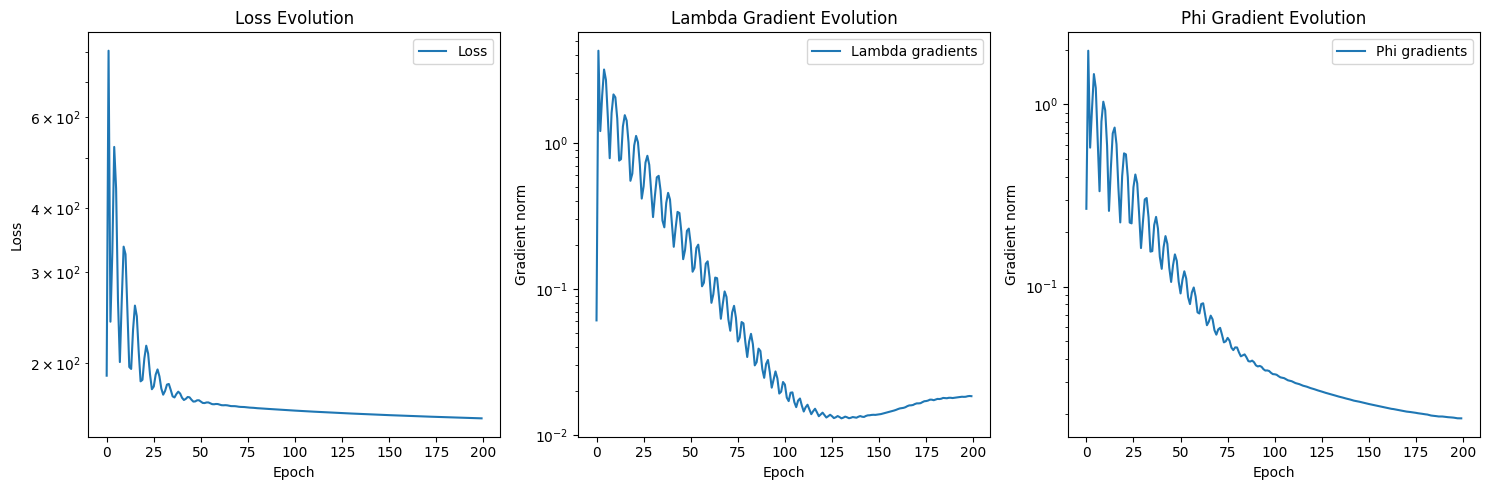

In [72]:
plot_training_evolution(history_new)

In [74]:
## do the cluster assignemtns still map?

final_psi = model.psi.detach()
# Get the signature with maximum psi for each disease
max_psi_indices = torch.argmax(final_psi, dim=0)  # Shape: [D]

# Compare with cluster assignments
matches = 0
total = len(model.clusters)

print("Comparing max psi signatures with cluster assignments:")
for k in range(model.K):
    # Find diseases assigned to cluster k
    cluster_diseases = np.where(model.clusters == k)[0]
    # Find diseases where k has maximum psi
    max_psi_diseases = np.where(max_psi_indices == k)[0]
    
    overlap = set(cluster_diseases) & set(max_psi_diseases)
    
    print(f"\nCluster {k}:")
    print(f"Number of diseases in cluster: {len(cluster_diseases)}")
    print(f"Number of diseases where this signature has max psi: {len(max_psi_diseases)}")
    print(f"Overlap: {len(overlap)}")
    
    matches += len(overlap)

print(f"\nOverall agreement: {matches}/{total} diseases ({matches/total*100:.1f}%)")

Comparing max psi signatures with cluster assignments:

Cluster 0:
Number of diseases in cluster: 4
Number of diseases where this signature has max psi: 4
Overlap: 4

Cluster 1:
Number of diseases in cluster: 38
Number of diseases where this signature has max psi: 38
Overlap: 38

Cluster 2:
Number of diseases in cluster: 10
Number of diseases where this signature has max psi: 10
Overlap: 10

Cluster 3:
Number of diseases in cluster: 18
Number of diseases where this signature has max psi: 18
Overlap: 18

Cluster 4:
Number of diseases in cluster: 8
Number of diseases where this signature has max psi: 8
Overlap: 8

Cluster 5:
Number of diseases in cluster: 67
Number of diseases where this signature has max psi: 67
Overlap: 67

Cluster 6:
Number of diseases in cluster: 20
Number of diseases where this signature has max psi: 20
Overlap: 20

Cluster 7:
Number of diseases in cluster: 23
Number of diseases where this signature has max psi: 23
Overlap: 23

Cluster 8:
Number of diseases in clust

In [75]:
final_lambda = model.lambda_.detach().clone()
diff = torch.abs(final_lambda - initial_lambda)

print(f"Lambda changes with lr=1e-2:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Lambda changes with lr=1e-2:
Mean absolute change: 1.405e-01
Max absolute change: 9.470e+00
Std of changes: 2.803e-01


In [79]:
model.clusters

array([12,  5,  1,  1,  1,  1,  1, 13,  3,  3,  5,  5,  5, 11, 13, 13,  0,
        0,  7,  5,  5,  5,  5,  5, 11, 11, 11, 11, 11, 11, 11, 13,  5, 12,
        5, 12,  5,  5,  5, 13,  7,  5, 13,  5,  5,  5, 14, 14, 14, 14,  1,
       14, 14,  5,  1,  1, 14,  1,  1,  1, 14, 12,  1,  1,  5,  1,  1,  1,
        1,  1,  1,  3, 14,  5,  9,  5,  3,  4,  1,  6,  5,  1,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  5,  8,
        3,  5,  5, 16, 16,  5, 16, 14, 14, 16, 16, 16, 16, 16,  1, 16, 16,
       16, 16, 16, 16,  5, 16, 16, 16, 16,  5, 16, 16, 16,  4,  4,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  5, 12,  5,  1,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3, 19, 19, 19,  3, 19, 19, 19, 19, 19, 19, 19, 19,
       19,  3,  5,  1,  1,  5,  1,  3,  5, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12,  5,  5, 12,  5,  5, 12, 12,  5, 12, 12, 12,
        1, 12, 12, 12, 12, 12,  5, 12, 12,  1,  1, 10, 10, 10, 10, 10, 10,
        5,  1, 12, 12, 12

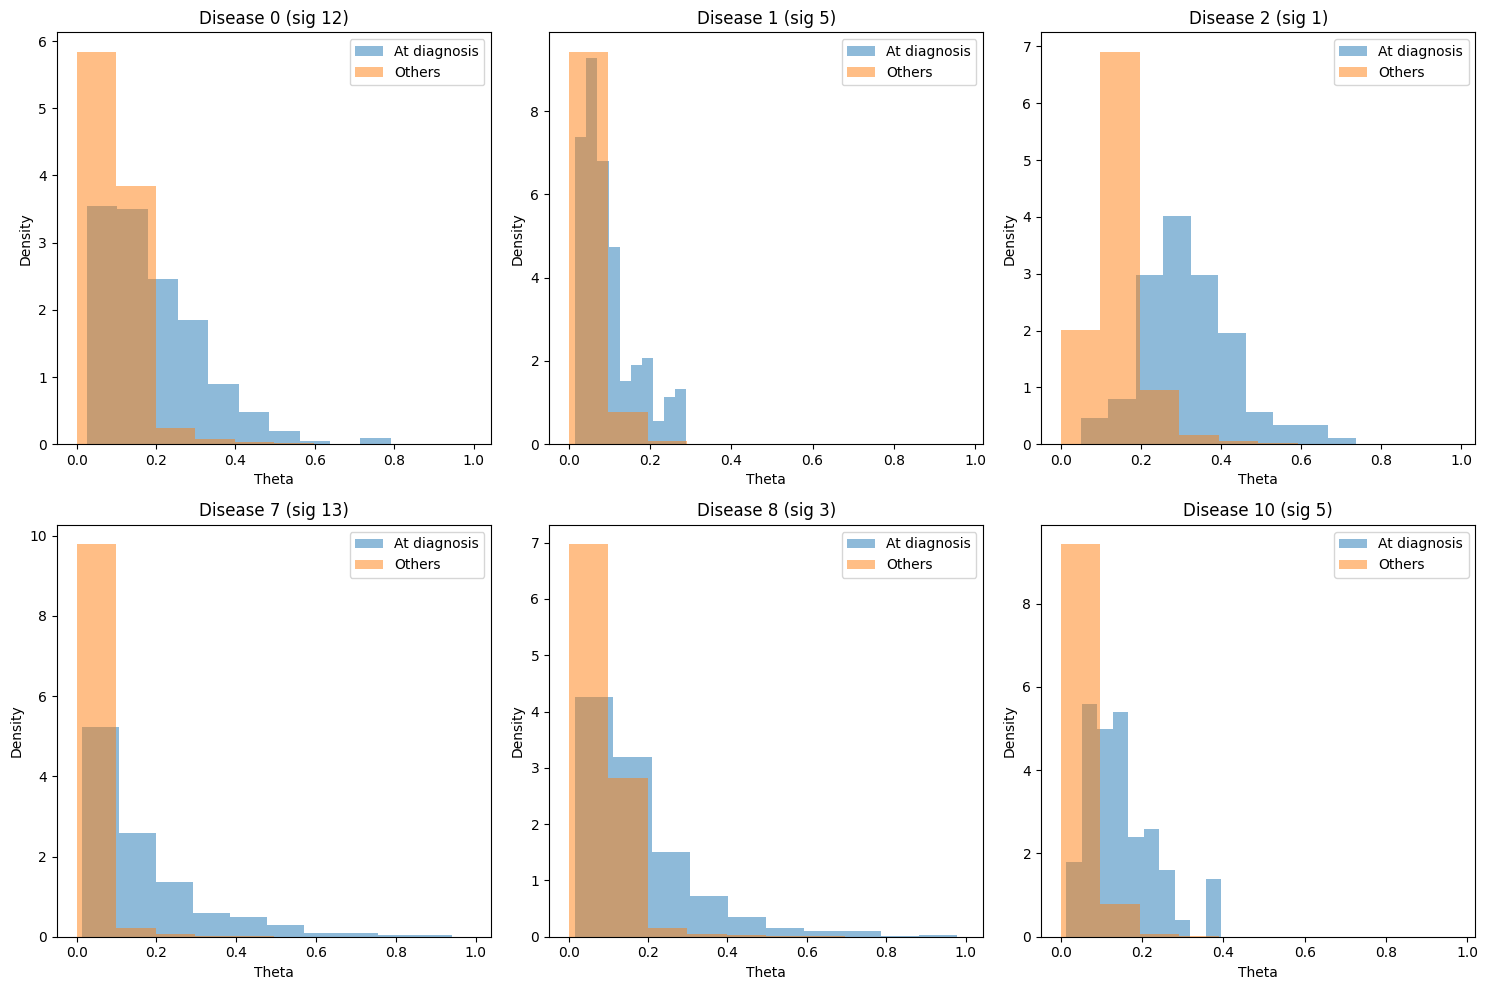

In [80]:
def plot_theta_differences():
    diseases = [0, 1, 2,7, 8,10]
    signatures = [12, 5, 1, 13, 3, 5]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (d, sig) in enumerate(zip(diseases, signatures)):
        ax = axes[i]
        
        # Get diagnosis times
        diagnosis_mask = model.Y[:, d, :].bool()
        diagnosed = torch.where(diagnosis_mask)[0]
        
        # Get thetas
        pi, theta, phi_prob = model.forward()
        
        # Plot distributions
        diagnosed_theta = theta[diagnosis_mask, sig].detach().numpy()
        others_theta = theta[~diagnosis_mask, sig].detach().numpy()
        
        ax.hist(diagnosed_theta, alpha=0.5, label='At diagnosis', density=True)
        ax.hist(others_theta, alpha=0.5, label='Others', density=True)
        
        ax.set_title(f'Disease {d} (sig {sig})')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_theta_differences()

In [ ]:

torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'initial_phi': initial_phi, 
    'initial_lambda': initial_lambda, 
    'psi': model.psi,
    'Y': Y_100k,
    'prevalence_t': essentials['prevalence_t'],
    'logit_prevalence_t': model.logit_prev_t,
    'G': G_100k,
    'E': E_100k,
    'indices': indices,
    'disease_names': essentials['disease_names'],
    'hyperparameters': {
        'N': Y_100k.shape[0],
        'D': Y_100k.shape[1],
        'T': Y_100k.shape[2],
        'P': G_100k.shape[1],
        'K': model.phi.shape[0]
    }
}, model_save_path)

In [ ]:

torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'initial_phi': initial_phi, 
    'initial_lambda': initial_lambda, 
    'psi': model.psi,
    'Y': Y_100k,
    'prevalence_t': essentials['prevalence_t'],
    'logit_prevalence_t': model.logit_prev_t,
    'G': G_100k,
    'E': E_100k,
    'indices': indices,
    'disease_names': essentials['disease_names'],
    'hyperparameters': {
        'N': Y_100k.shape[0],
        'D': Y_100k.shape[1],
        'T': Y_100k.shape[2],
        'P': G_100k.shape[1],
        'K': model.phi.shape[0]
    }
}, model_save_path)

In [ ]:

torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'initial_phi': initial_phi, 
    'initial_lambda': initial_lambda, 
    'psi': model.psi,
    'Y': Y_100k,
    'prevalence_t': essentials['prevalence_t'],
    'logit_prevalence_t': model.logit_prev_t,
    'G': G_100k,
    'E': E_100k,
    'indices': indices,
    'disease_names': essentials['disease_names'],
    'hyperparameters': {
        'N': Y_100k.shape[0],
        'D': Y_100k.shape[1],
        'T': Y_100k.shape[2],
        'P': G_100k.shape[1],
        'K': model.phi.shape[0]
    }
}, model_save_path)

In [ ]:

torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'initial_phi': initial_phi, 
    'initial_lambda': initial_lambda, 
    'psi': model.psi,
    'Y': Y_100k,
    'prevalence_t': essentials['prevalence_t'],
    'logit_prevalence_t': model.logit_prev_t,
    'G': G_100k,
    'E': E_100k,
    'indices': indices,
    'disease_names': essentials['disease_names'],
    'hyperparameters': {
        'N': Y_100k.shape[0],
        'D': Y_100k.shape[1],
        'T': Y_100k.shape[2],
        'P': G_100k.shape[1],
        'K': model.phi.shape[0]
    }
}, model_save_path)

In [ ]:
checkpoints=torch.load(model_save_path)

Number of diseases: 348, Number of timepoints: 52
Overall mean predicted risk: 0.000464
Overall mean observed risk: 0.000401
Overall calibration factor: 0.8632


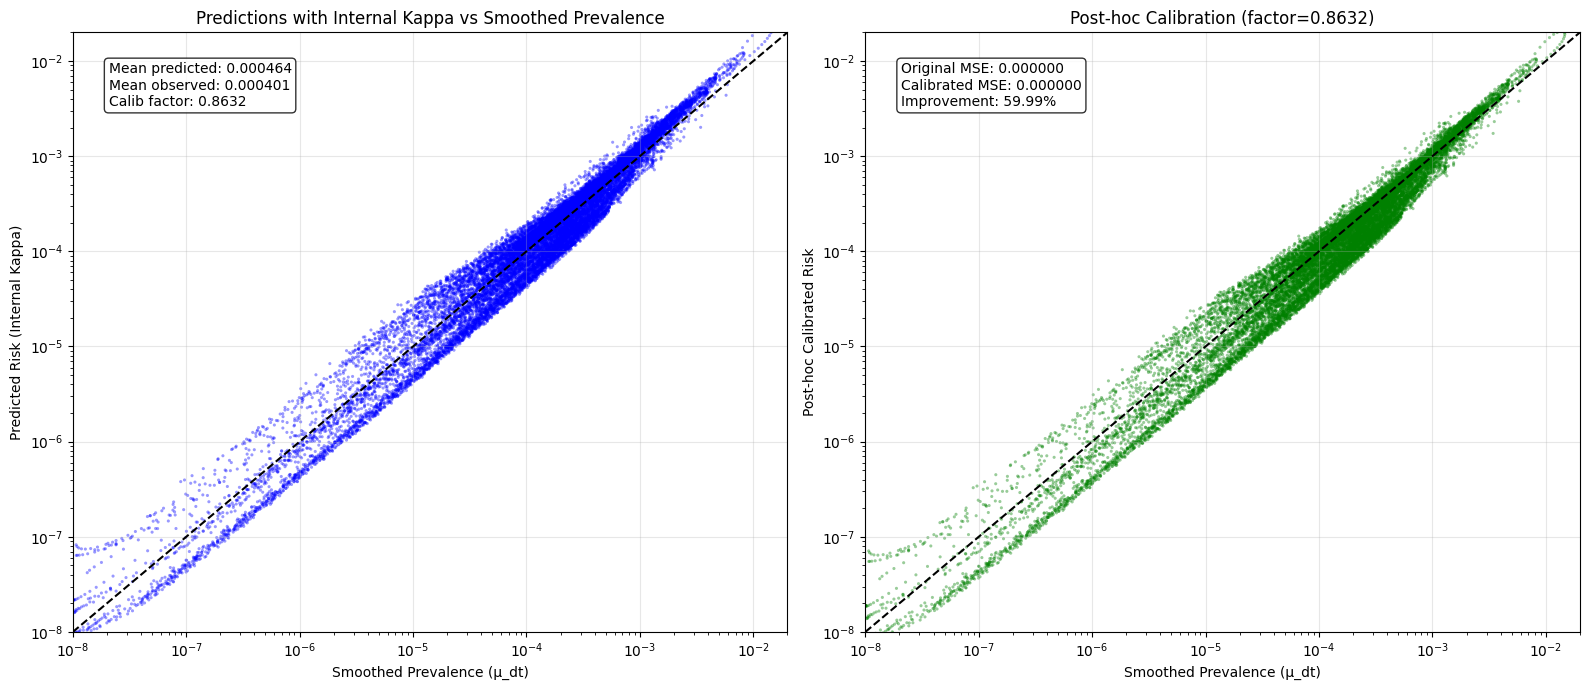


Calibration with Internal Kappa:
Mean predicted risk: 0.000464
Mean observed prevalence: 0.000401
Calibration factor needed: 0.8632
MSE before post-hoc calibration: 0.000000
MSE after post-hoc calibration: 0.000000
Improvement from post-hoc calibration: 59.99%


In [ ]:
def analyze_internal_kappa_calibration(model, mu_dt):
    """
    Analyze calibration for a model with internal kappa implementation
    
    Args:
        model: The loaded model with internal kappa
        mu_dt: The observed prevalence matrix
    
    Returns:
        Calibration plot figure
    """
    # Get predictions from the model
    with torch.no_grad():
        pi, theta, phi_prob = model.forward()
    
    # Convert to numpy for analysis
    pi_np = pi.detach().numpy()
    
    # Aggregate predictions and observations
    all_pi_values = []
    all_mu_dt_values = []
    
    n_diseases, n_timepoints = mu_dt.shape
    print(f"Number of diseases: {n_diseases}, Number of timepoints: {n_timepoints}")
    
    # Aggregate pi values for each disease and timepoint
    for d in range(n_diseases):
        for t in range(n_timepoints):
            # Get valid entries (non-NaN) for this disease and timepoint
            valid_mask = ~np.isnan(pi_np[:, d, t])
            n_valid = np.sum(valid_mask)
            
            if n_valid > 0:
                avg_pi_dt = np.mean(pi_np[valid_mask, d, t])
                all_pi_values.append(avg_pi_dt)
                all_mu_dt_values.append(mu_dt[d, t])
    
    # Convert to numpy arrays
    all_pi_values = np.array(all_pi_values)
    all_mu_dt_values = np.array(all_mu_dt_values)
    
    # Calculate calibration factor
    valid_mask = (all_pi_values > 0) & (all_mu_dt_values > 0)
    pi_valid = all_pi_values[valid_mask]
    mu_dt_valid = all_mu_dt_values[valid_mask]
    
    mean_pred = np.mean(pi_valid)
    mean_obs = np.mean(mu_dt_valid)
    calib_factor = mean_obs / mean_pred
    
    print(f"Overall mean predicted risk: {mean_pred:.6f}")
    print(f"Overall mean observed risk: {mean_obs:.6f}")
    print(f"Overall calibration factor: {calib_factor:.4f}")
    
    # Create figure with two plots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Original predictions vs. smoothed prevalence
    ax1.scatter(mu_dt_valid, pi_valid, alpha=0.4, s=5, color='blue', edgecolor='none')
    ax1.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Predicted Risk (Internal Kappa)')
    ax1.set_title('Predictions with Internal Kappa vs Smoothed Prevalence')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-8, 2e-2)
    ax1.set_ylim(1e-8, 2e-2)
    ax1.grid(True, alpha=0.3)
    
    # Add text with calibration metrics
    ax1.text(0.05, 0.95, 
             f"Mean predicted: {mean_pred:.6f}\nMean observed: {mean_obs:.6f}\nCalib factor: {calib_factor:.4f}", 
             transform=ax1.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Post-hoc calibrated predictions
    scaled_pi = pi_valid * calib_factor
    
    ax2.scatter(mu_dt_valid, scaled_pi, alpha=0.4, s=5, color='green', edgecolor='none')
    ax2.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Post-hoc Calibrated Risk')
    ax2.set_title(f'Post-hoc Calibration (factor={calib_factor:.4f})')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1e-8, 2e-2)
    ax2.set_ylim(1e-8, 2e-2)
    ax2.grid(True, alpha=0.3)
    
    # Add text with calibration improvement metrics
    mse_orig = np.mean((pi_valid - mu_dt_valid)**2)
    mse_calib = np.mean((scaled_pi - mu_dt_valid)**2)
    improvement = (mse_orig - mse_calib) / mse_orig * 100
    
    ax2.text(0.05, 0.95, 
             f"Original MSE: {mse_orig:.6f}\nCalibrated MSE: {mse_calib:.6f}\nImprovement: {improvement:.2f}%", 
             transform=ax2.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nCalibration with Internal Kappa:")
    print(f"Mean predicted risk: {mean_pred:.6f}")
    print(f"Mean observed prevalence: {mean_obs:.6f}")
    print(f"Calibration factor needed: {calib_factor:.4f}")
    print(f"MSE before post-hoc calibration: {mse_orig:.6f}")
    print(f"MSE after post-hoc calibration: {mse_calib:.6f}")
    print(f"Improvement from post-hoc calibration: {improvement:.2f}%")
    
    return fig, all_pi_values, all_mu_dt_values, calib_factor

# Usage example:
# Assuming you have your model and mu_dt (prevalence matrix) available
mu_dt = essentials['prevalence_t'] # Shape: (348, 52)
fig, all_pi, all_mu_dt, calib_factor = analyze_internal_kappa_calibration(model, mu_dt)

Number of diseases: 348, Number of timepoints: 52
Overall mean predicted risk: 0.000464
Overall mean observed risk: 0.000401
Overall calibration factor: 0.8632


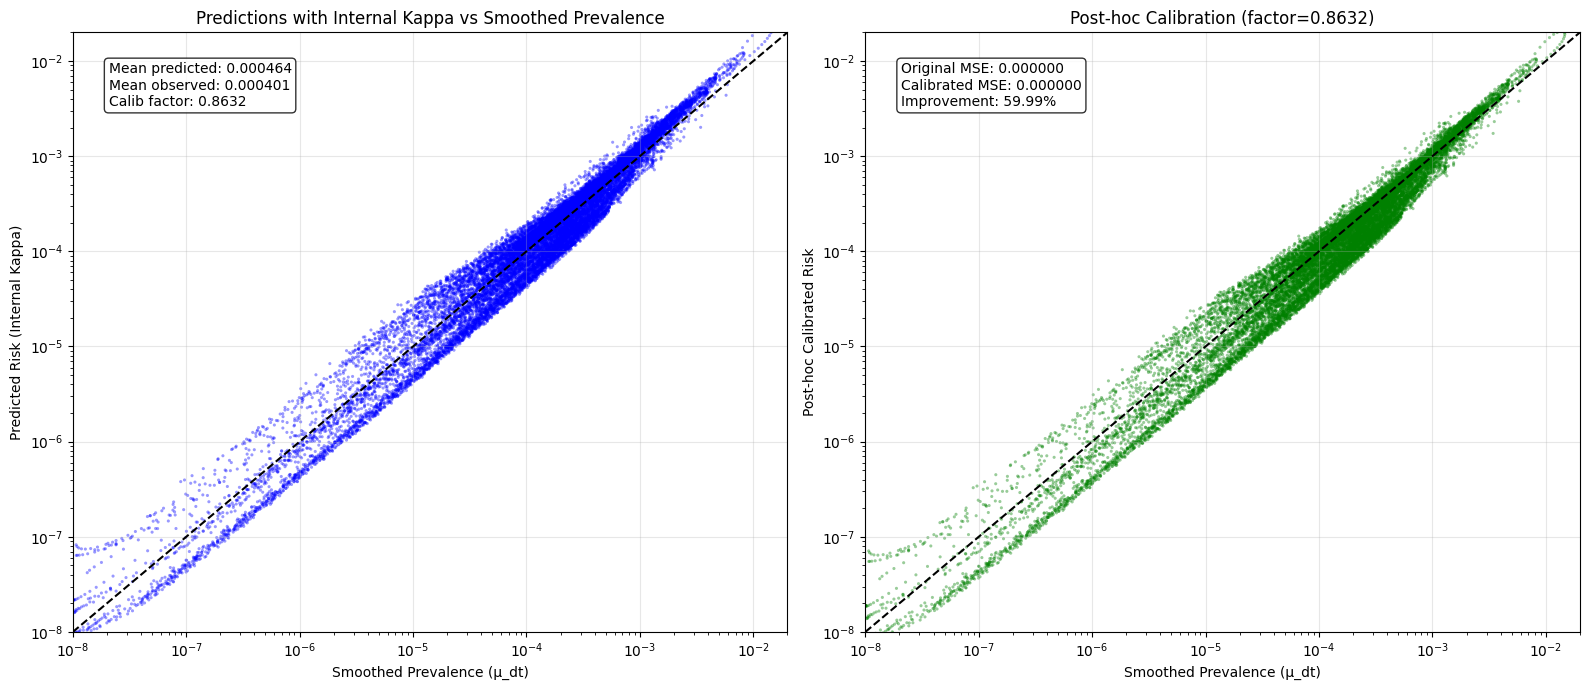


Calibration with Internal Kappa:
Mean predicted risk: 0.000464
Mean observed prevalence: 0.000401
Calibration factor needed: 0.8632
MSE before post-hoc calibration: 0.000000
MSE after post-hoc calibration: 0.000000
Improvement from post-hoc calibration: 59.99%


In [ ]:
def analyze_internal_kappa_calibration(model, mu_dt):
    """
    Analyze calibration for a model with internal kappa implementation
    
    Args:
        model: The loaded model with internal kappa
        mu_dt: The observed prevalence matrix
    
    Returns:
        Calibration plot figure
    """
    # Get predictions from the model
    with torch.no_grad():
        pi, theta, phi_prob = model.forward()
    
    # Convert to numpy for analysis
    pi_np = pi.detach().numpy()
    
    # Aggregate predictions and observations
    all_pi_values = []
    all_mu_dt_values = []
    
    n_diseases, n_timepoints = mu_dt.shape
    print(f"Number of diseases: {n_diseases}, Number of timepoints: {n_timepoints}")
    
    # Aggregate pi values for each disease and timepoint
    for d in range(n_diseases):
        for t in range(n_timepoints):
            # Get valid entries (non-NaN) for this disease and timepoint
            valid_mask = ~np.isnan(pi_np[:, d, t])
            n_valid = np.sum(valid_mask)
            
            if n_valid > 0:
                avg_pi_dt = np.mean(pi_np[valid_mask, d, t])
                all_pi_values.append(avg_pi_dt)
                all_mu_dt_values.append(mu_dt[d, t])
    
    # Convert to numpy arrays
    all_pi_values = np.array(all_pi_values)
    all_mu_dt_values = np.array(all_mu_dt_values)
    
    # Calculate calibration factor
    valid_mask = (all_pi_values > 0) & (all_mu_dt_values > 0)
    pi_valid = all_pi_values[valid_mask]
    mu_dt_valid = all_mu_dt_values[valid_mask]
    
    mean_pred = np.mean(pi_valid)
    mean_obs = np.mean(mu_dt_valid)
    calib_factor = mean_obs / mean_pred
    
    print(f"Overall mean predicted risk: {mean_pred:.6f}")
    print(f"Overall mean observed risk: {mean_obs:.6f}")
    print(f"Overall calibration factor: {calib_factor:.4f}")
    
    # Create figure with two plots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Original predictions vs. smoothed prevalence
    ax1.scatter(mu_dt_valid, pi_valid, alpha=0.4, s=5, color='blue', edgecolor='none')
    ax1.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Predicted Risk (Internal Kappa)')
    ax1.set_title('Predictions with Internal Kappa vs Smoothed Prevalence')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-8, 2e-2)
    ax1.set_ylim(1e-8, 2e-2)
    ax1.grid(True, alpha=0.3)
    
    # Add text with calibration metrics
    ax1.text(0.05, 0.95, 
             f"Mean predicted: {mean_pred:.6f}\nMean observed: {mean_obs:.6f}\nCalib factor: {calib_factor:.4f}", 
             transform=ax1.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Post-hoc calibrated predictions
    scaled_pi = pi_valid * calib_factor
    
    ax2.scatter(mu_dt_valid, scaled_pi, alpha=0.4, s=5, color='green', edgecolor='none')
    ax2.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Post-hoc Calibrated Risk')
    ax2.set_title(f'Post-hoc Calibration (factor={calib_factor:.4f})')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1e-8, 2e-2)
    ax2.set_ylim(1e-8, 2e-2)
    ax2.grid(True, alpha=0.3)
    
    # Add text with calibration improvement metrics
    mse_orig = np.mean((pi_valid - mu_dt_valid)**2)
    mse_calib = np.mean((scaled_pi - mu_dt_valid)**2)
    improvement = (mse_orig - mse_calib) / mse_orig * 100
    
    ax2.text(0.05, 0.95, 
             f"Original MSE: {mse_orig:.6f}\nCalibrated MSE: {mse_calib:.6f}\nImprovement: {improvement:.2f}%", 
             transform=ax2.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nCalibration with Internal Kappa:")
    print(f"Mean predicted risk: {mean_pred:.6f}")
    print(f"Mean observed prevalence: {mean_obs:.6f}")
    print(f"Calibration factor needed: {calib_factor:.4f}")
    print(f"MSE before post-hoc calibration: {mse_orig:.6f}")
    print(f"MSE after post-hoc calibration: {mse_calib:.6f}")
    print(f"Improvement from post-hoc calibration: {improvement:.2f}%")
    
    return fig, all_pi_values, all_mu_dt_values, calib_factor

# Usage example:
# Assuming you have your model and mu_dt (prevalence matrix) available
mu_dt = essentials['prevalence_t'] # Shape: (348, 52)
fig, all_pi, all_mu_dt, calib_factor = analyze_internal_kappa_calibration(model, mu_dt)

Number of diseases: 348, Number of timepoints: 52
Overall mean predicted risk: 0.000464
Overall mean observed risk: 0.000401
Overall calibration factor: 0.8632


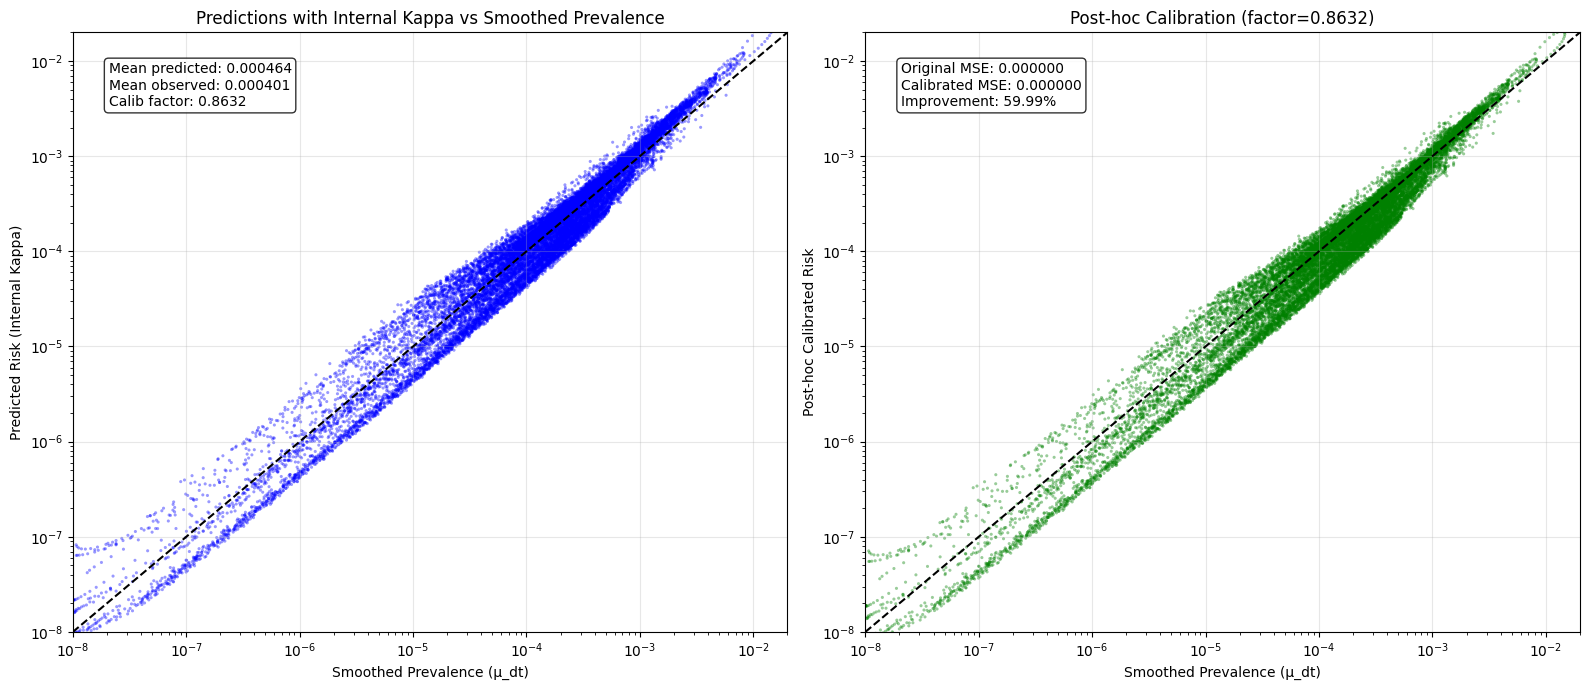


Calibration with Internal Kappa:
Mean predicted risk: 0.000464
Mean observed prevalence: 0.000401
Calibration factor needed: 0.8632
MSE before post-hoc calibration: 0.000000
MSE after post-hoc calibration: 0.000000
Improvement from post-hoc calibration: 59.99%


In [ ]:
def analyze_internal_kappa_calibration(model, mu_dt):
    """
    Analyze calibration for a model with internal kappa implementation
    
    Args:
        model: The loaded model with internal kappa
        mu_dt: The observed prevalence matrix
    
    Returns:
        Calibration plot figure
    """
    # Get predictions from the model
    with torch.no_grad():
        pi, theta, phi_prob = model.forward()
    
    # Convert to numpy for analysis
    pi_np = pi.detach().numpy()
    
    # Aggregate predictions and observations
    all_pi_values = []
    all_mu_dt_values = []
    
    n_diseases, n_timepoints = mu_dt.shape
    print(f"Number of diseases: {n_diseases}, Number of timepoints: {n_timepoints}")
    
    # Aggregate pi values for each disease and timepoint
    for d in range(n_diseases):
        for t in range(n_timepoints):
            # Get valid entries (non-NaN) for this disease and timepoint
            valid_mask = ~np.isnan(pi_np[:, d, t])
            n_valid = np.sum(valid_mask)
            
            if n_valid > 0:
                avg_pi_dt = np.mean(pi_np[valid_mask, d, t])
                all_pi_values.append(avg_pi_dt)
                all_mu_dt_values.append(mu_dt[d, t])
    
    # Convert to numpy arrays
    all_pi_values = np.array(all_pi_values)
    all_mu_dt_values = np.array(all_mu_dt_values)
    
    # Calculate calibration factor
    valid_mask = (all_pi_values > 0) & (all_mu_dt_values > 0)
    pi_valid = all_pi_values[valid_mask]
    mu_dt_valid = all_mu_dt_values[valid_mask]
    
    mean_pred = np.mean(pi_valid)
    mean_obs = np.mean(mu_dt_valid)
    calib_factor = mean_obs / mean_pred
    
    print(f"Overall mean predicted risk: {mean_pred:.6f}")
    print(f"Overall mean observed risk: {mean_obs:.6f}")
    print(f"Overall calibration factor: {calib_factor:.4f}")
    
    # Create figure with two plots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Original predictions vs. smoothed prevalence
    ax1.scatter(mu_dt_valid, pi_valid, alpha=0.4, s=5, color='blue', edgecolor='none')
    ax1.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Predicted Risk (Internal Kappa)')
    ax1.set_title('Predictions with Internal Kappa vs Smoothed Prevalence')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-8, 2e-2)
    ax1.set_ylim(1e-8, 2e-2)
    ax1.grid(True, alpha=0.3)
    
    # Add text with calibration metrics
    ax1.text(0.05, 0.95, 
             f"Mean predicted: {mean_pred:.6f}\nMean observed: {mean_obs:.6f}\nCalib factor: {calib_factor:.4f}", 
             transform=ax1.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Post-hoc calibrated predictions
    scaled_pi = pi_valid * calib_factor
    
    ax2.scatter(mu_dt_valid, scaled_pi, alpha=0.4, s=5, color='green', edgecolor='none')
    ax2.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Post-hoc Calibrated Risk')
    ax2.set_title(f'Post-hoc Calibration (factor={calib_factor:.4f})')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1e-8, 2e-2)
    ax2.set_ylim(1e-8, 2e-2)
    ax2.grid(True, alpha=0.3)
    
    # Add text with calibration improvement metrics
    mse_orig = np.mean((pi_valid - mu_dt_valid)**2)
    mse_calib = np.mean((scaled_pi - mu_dt_valid)**2)
    improvement = (mse_orig - mse_calib) / mse_orig * 100
    
    ax2.text(0.05, 0.95, 
             f"Original MSE: {mse_orig:.6f}\nCalibrated MSE: {mse_calib:.6f}\nImprovement: {improvement:.2f}%", 
             transform=ax2.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nCalibration with Internal Kappa:")
    print(f"Mean predicted risk: {mean_pred:.6f}")
    print(f"Mean observed prevalence: {mean_obs:.6f}")
    print(f"Calibration factor needed: {calib_factor:.4f}")
    print(f"MSE before post-hoc calibration: {mse_orig:.6f}")
    print(f"MSE after post-hoc calibration: {mse_calib:.6f}")
    print(f"Improvement from post-hoc calibration: {improvement:.2f}%")
    
    return fig, all_pi_values, all_mu_dt_values, calib_factor

# Usage example:
# Assuming you have your model and mu_dt (prevalence matrix) available
mu_dt = essentials['prevalence_t'] # Shape: (348, 52)
fig, all_pi, all_mu_dt, calib_factor = analyze_internal_kappa_calibration(model, mu_dt)

Number of diseases: 348, Number of timepoints: 52
Overall mean predicted risk: 0.000464
Overall mean observed risk: 0.000401
Overall calibration factor: 0.8632


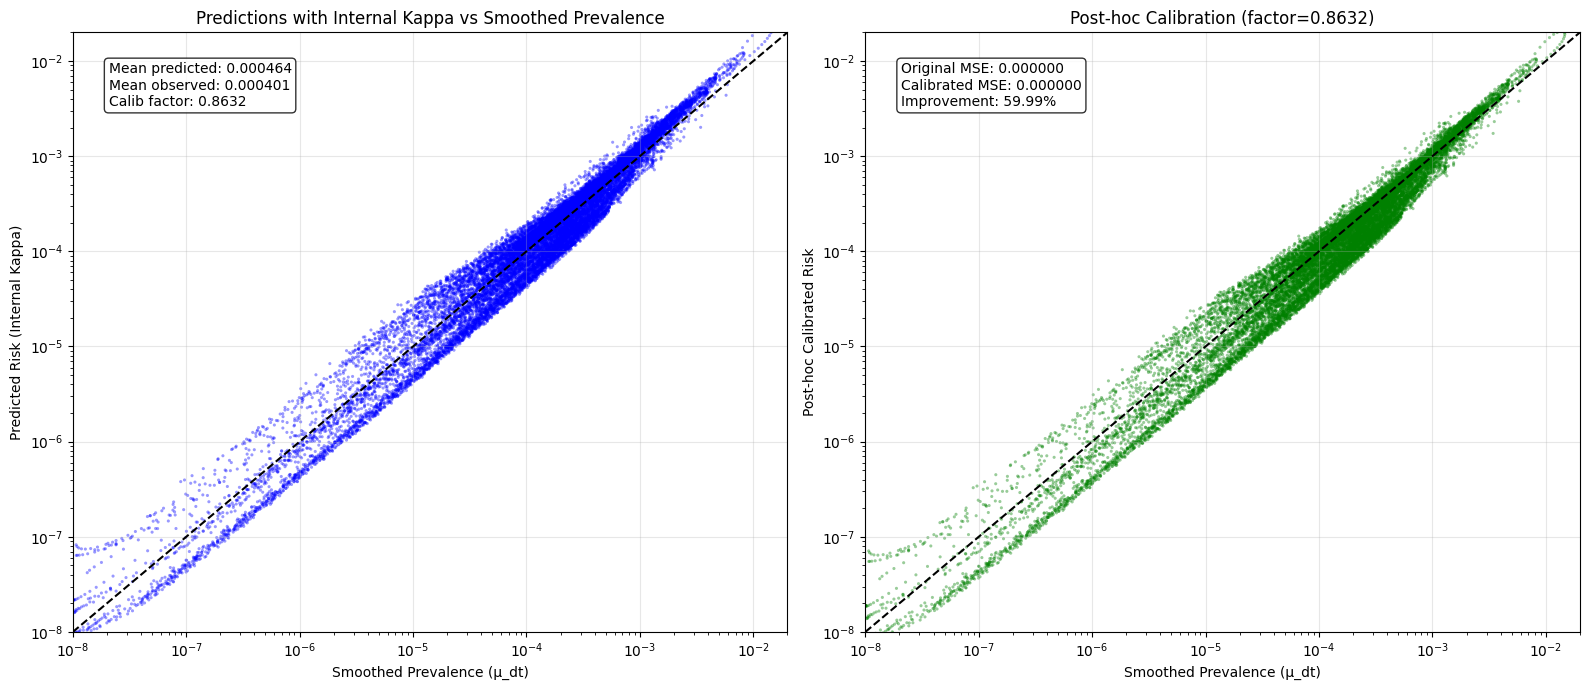


Calibration with Internal Kappa:
Mean predicted risk: 0.000464
Mean observed prevalence: 0.000401
Calibration factor needed: 0.8632
MSE before post-hoc calibration: 0.000000
MSE after post-hoc calibration: 0.000000
Improvement from post-hoc calibration: 59.99%


In [ ]:
def analyze_internal_kappa_calibration(model, mu_dt):
    """
    Analyze calibration for a model with internal kappa implementation
    
    Args:
        model: The loaded model with internal kappa
        mu_dt: The observed prevalence matrix
    
    Returns:
        Calibration plot figure
    """
    # Get predictions from the model
    with torch.no_grad():
        pi, theta, phi_prob = model.forward()
    
    # Convert to numpy for analysis
    pi_np = pi.detach().numpy()
    
    # Aggregate predictions and observations
    all_pi_values = []
    all_mu_dt_values = []
    
    n_diseases, n_timepoints = mu_dt.shape
    print(f"Number of diseases: {n_diseases}, Number of timepoints: {n_timepoints}")
    
    # Aggregate pi values for each disease and timepoint
    for d in range(n_diseases):
        for t in range(n_timepoints):
            # Get valid entries (non-NaN) for this disease and timepoint
            valid_mask = ~np.isnan(pi_np[:, d, t])
            n_valid = np.sum(valid_mask)
            
            if n_valid > 0:
                avg_pi_dt = np.mean(pi_np[valid_mask, d, t])
                all_pi_values.append(avg_pi_dt)
                all_mu_dt_values.append(mu_dt[d, t])
    
    # Convert to numpy arrays
    all_pi_values = np.array(all_pi_values)
    all_mu_dt_values = np.array(all_mu_dt_values)
    
    # Calculate calibration factor
    valid_mask = (all_pi_values > 0) & (all_mu_dt_values > 0)
    pi_valid = all_pi_values[valid_mask]
    mu_dt_valid = all_mu_dt_values[valid_mask]
    
    mean_pred = np.mean(pi_valid)
    mean_obs = np.mean(mu_dt_valid)
    calib_factor = mean_obs / mean_pred
    
    print(f"Overall mean predicted risk: {mean_pred:.6f}")
    print(f"Overall mean observed risk: {mean_obs:.6f}")
    print(f"Overall calibration factor: {calib_factor:.4f}")
    
    # Create figure with two plots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Original predictions vs. smoothed prevalence
    ax1.scatter(mu_dt_valid, pi_valid, alpha=0.4, s=5, color='blue', edgecolor='none')
    ax1.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Predicted Risk (Internal Kappa)')
    ax1.set_title('Predictions with Internal Kappa vs Smoothed Prevalence')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-8, 2e-2)
    ax1.set_ylim(1e-8, 2e-2)
    ax1.grid(True, alpha=0.3)
    
    # Add text with calibration metrics
    ax1.text(0.05, 0.95, 
             f"Mean predicted: {mean_pred:.6f}\nMean observed: {mean_obs:.6f}\nCalib factor: {calib_factor:.4f}", 
             transform=ax1.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Post-hoc calibrated predictions
    scaled_pi = pi_valid * calib_factor
    
    ax2.scatter(mu_dt_valid, scaled_pi, alpha=0.4, s=5, color='green', edgecolor='none')
    ax2.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Post-hoc Calibrated Risk')
    ax2.set_title(f'Post-hoc Calibration (factor={calib_factor:.4f})')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1e-8, 2e-2)
    ax2.set_ylim(1e-8, 2e-2)
    ax2.grid(True, alpha=0.3)
    
    # Add text with calibration improvement metrics
    mse_orig = np.mean((pi_valid - mu_dt_valid)**2)
    mse_calib = np.mean((scaled_pi - mu_dt_valid)**2)
    improvement = (mse_orig - mse_calib) / mse_orig * 100
    
    ax2.text(0.05, 0.95, 
             f"Original MSE: {mse_orig:.6f}\nCalibrated MSE: {mse_calib:.6f}\nImprovement: {improvement:.2f}%", 
             transform=ax2.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nCalibration with Internal Kappa:")
    print(f"Mean predicted risk: {mean_pred:.6f}")
    print(f"Mean observed prevalence: {mean_obs:.6f}")
    print(f"Calibration factor needed: {calib_factor:.4f}")
    print(f"MSE before post-hoc calibration: {mse_orig:.6f}")
    print(f"MSE after post-hoc calibration: {mse_calib:.6f}")
    print(f"Improvement from post-hoc calibration: {improvement:.2f}%")
    
    return fig, all_pi_values, all_mu_dt_values, calib_factor

# Usage example:
# Assuming you have your model and mu_dt (prevalence matrix) available
mu_dt = essentials['prevalence_t'] # Shape: (348, 52)
fig, all_pi, all_mu_dt, calib_factor = analyze_internal_kappa_calibration(model, mu_dt)

Number of diseases: 348, Number of timepoints: 52
Overall mean predicted risk: 0.000464
Overall mean observed risk: 0.000401
Overall calibration factor: 0.8632


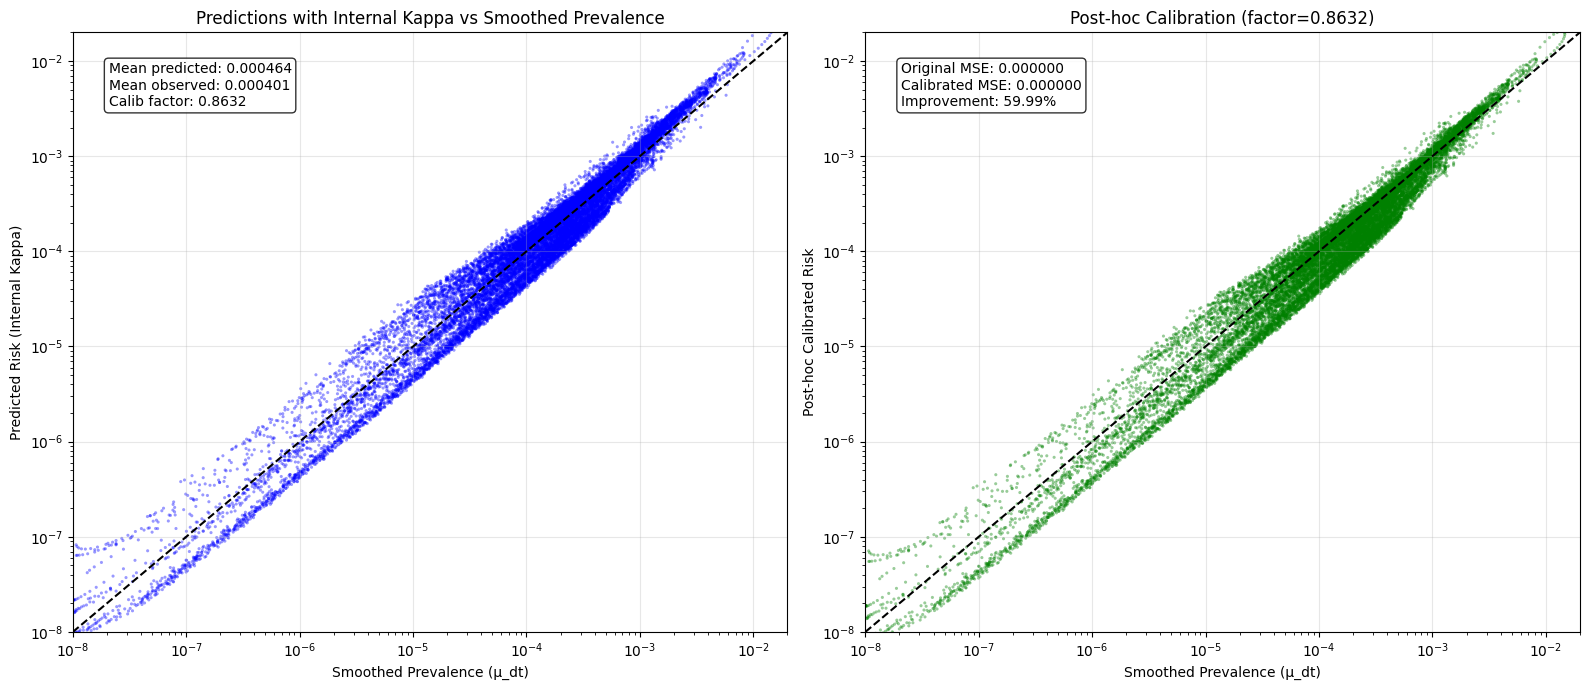


Calibration with Internal Kappa:
Mean predicted risk: 0.000464
Mean observed prevalence: 0.000401
Calibration factor needed: 0.8632
MSE before post-hoc calibration: 0.000000
MSE after post-hoc calibration: 0.000000
Improvement from post-hoc calibration: 59.99%


In [ ]:
def analyze_internal_kappa_calibration(model, mu_dt):
    """
    Analyze calibration for a model with internal kappa implementation
    
    Args:
        model: The loaded model with internal kappa
        mu_dt: The observed prevalence matrix
    
    Returns:
        Calibration plot figure
    """
    # Get predictions from the model
    with torch.no_grad():
        pi, theta, phi_prob = model.forward()
    
    # Convert to numpy for analysis
    pi_np = pi.detach().numpy()
    
    # Aggregate predictions and observations
    all_pi_values = []
    all_mu_dt_values = []
    
    n_diseases, n_timepoints = mu_dt.shape
    print(f"Number of diseases: {n_diseases}, Number of timepoints: {n_timepoints}")
    
    # Aggregate pi values for each disease and timepoint
    for d in range(n_diseases):
        for t in range(n_timepoints):
            # Get valid entries (non-NaN) for this disease and timepoint
            valid_mask = ~np.isnan(pi_np[:, d, t])
            n_valid = np.sum(valid_mask)
            
            if n_valid > 0:
                avg_pi_dt = np.mean(pi_np[valid_mask, d, t])
                all_pi_values.append(avg_pi_dt)
                all_mu_dt_values.append(mu_dt[d, t])
    
    # Convert to numpy arrays
    all_pi_values = np.array(all_pi_values)
    all_mu_dt_values = np.array(all_mu_dt_values)
    
    # Calculate calibration factor
    valid_mask = (all_pi_values > 0) & (all_mu_dt_values > 0)
    pi_valid = all_pi_values[valid_mask]
    mu_dt_valid = all_mu_dt_values[valid_mask]
    
    mean_pred = np.mean(pi_valid)
    mean_obs = np.mean(mu_dt_valid)
    calib_factor = mean_obs / mean_pred
    
    print(f"Overall mean predicted risk: {mean_pred:.6f}")
    print(f"Overall mean observed risk: {mean_obs:.6f}")
    print(f"Overall calibration factor: {calib_factor:.4f}")
    
    # Create figure with two plots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Original predictions vs. smoothed prevalence
    ax1.scatter(mu_dt_valid, pi_valid, alpha=0.4, s=5, color='blue', edgecolor='none')
    ax1.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Predicted Risk (Internal Kappa)')
    ax1.set_title('Predictions with Internal Kappa vs Smoothed Prevalence')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-8, 2e-2)
    ax1.set_ylim(1e-8, 2e-2)
    ax1.grid(True, alpha=0.3)
    
    # Add text with calibration metrics
    ax1.text(0.05, 0.95, 
             f"Mean predicted: {mean_pred:.6f}\nMean observed: {mean_obs:.6f}\nCalib factor: {calib_factor:.4f}", 
             transform=ax1.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Post-hoc calibrated predictions
    scaled_pi = pi_valid * calib_factor
    
    ax2.scatter(mu_dt_valid, scaled_pi, alpha=0.4, s=5, color='green', edgecolor='none')
    ax2.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Post-hoc Calibrated Risk')
    ax2.set_title(f'Post-hoc Calibration (factor={calib_factor:.4f})')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1e-8, 2e-2)
    ax2.set_ylim(1e-8, 2e-2)
    ax2.grid(True, alpha=0.3)
    
    # Add text with calibration improvement metrics
    mse_orig = np.mean((pi_valid - mu_dt_valid)**2)
    mse_calib = np.mean((scaled_pi - mu_dt_valid)**2)
    improvement = (mse_orig - mse_calib) / mse_orig * 100
    
    ax2.text(0.05, 0.95, 
             f"Original MSE: {mse_orig:.6f}\nCalibrated MSE: {mse_calib:.6f}\nImprovement: {improvement:.2f}%", 
             transform=ax2.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nCalibration with Internal Kappa:")
    print(f"Mean predicted risk: {mean_pred:.6f}")
    print(f"Mean observed prevalence: {mean_obs:.6f}")
    print(f"Calibration factor needed: {calib_factor:.4f}")
    print(f"MSE before post-hoc calibration: {mse_orig:.6f}")
    print(f"MSE after post-hoc calibration: {mse_calib:.6f}")
    print(f"Improvement from post-hoc calibration: {improvement:.2f}%")
    
    return fig, all_pi_values, all_mu_dt_values, calib_factor

# Usage example:
# Assuming you have your model and mu_dt (prevalence matrix) available
mu_dt = essentials['prevalence_t'] # Shape: (348, 52)
fig, all_pi, all_mu_dt, calib_factor = analyze_internal_kappa_calibration(model, mu_dt)

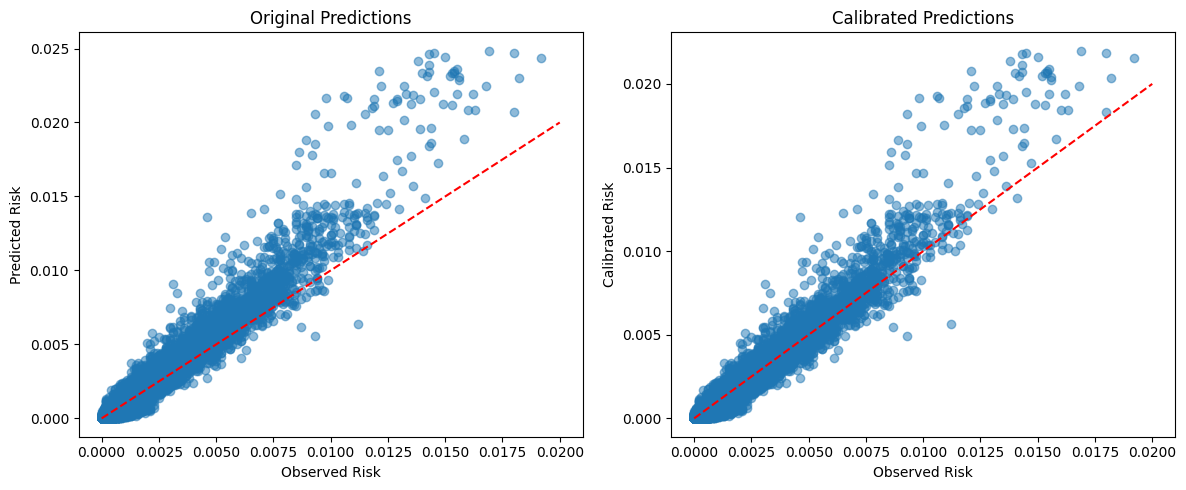

Mean observed risk: 0.001388
Mean predicted risk (original): 0.001569
Mean predicted risk (calibrated): 0.001388
Calibration scale factor: 0.885


In [81]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()
#observed_risk=mu_dt_flat
# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


Number of diseases: 348, Number of timepoints: 51
Overall mean predicted risk: 0.001569
Overall mean observed risk: 0.001265
Overall calibration factor: 0.8065


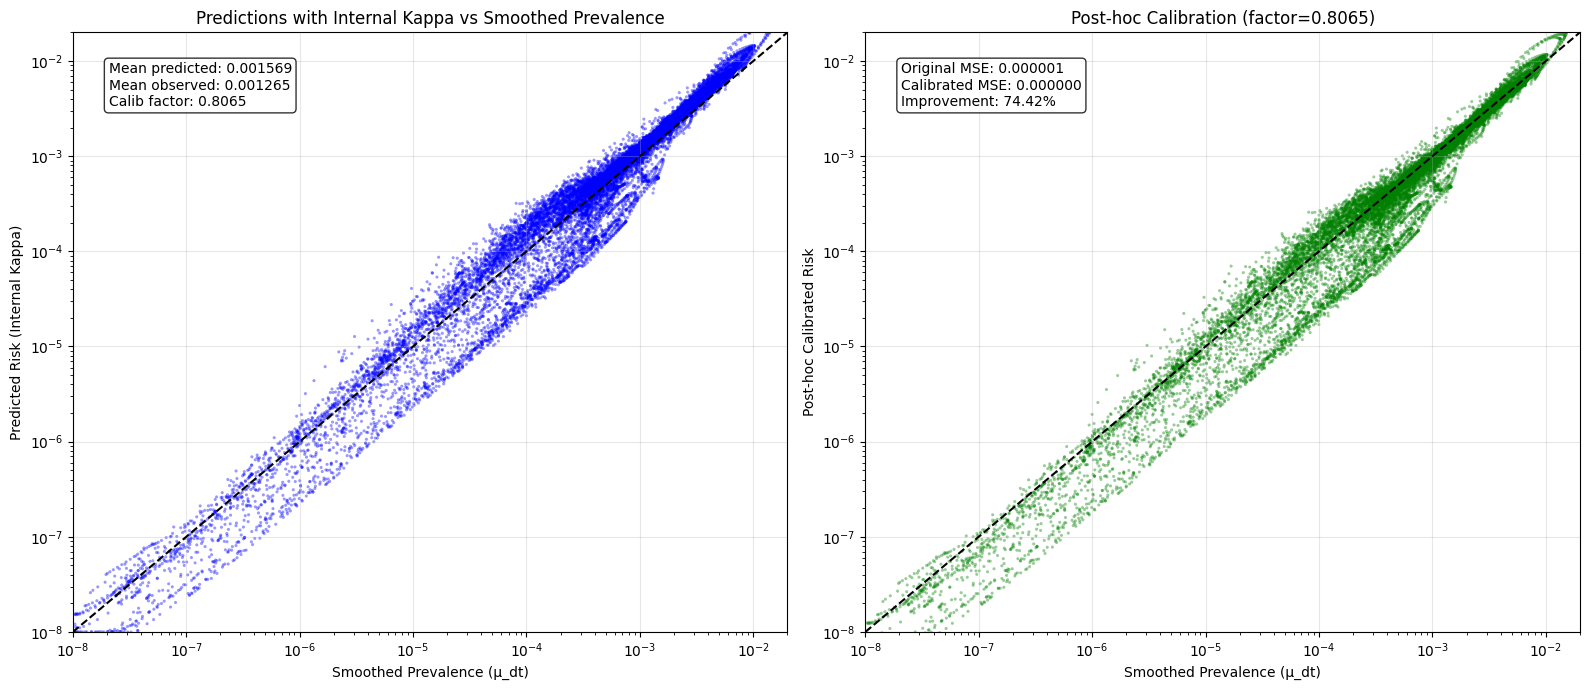


Calibration with Internal Kappa:
Mean predicted risk: 0.001569
Mean observed prevalence: 0.001265
Calibration factor needed: 0.8065
MSE before post-hoc calibration: 0.000001
MSE after post-hoc calibration: 0.000000
Improvement from post-hoc calibration: 74.42%


In [83]:
def analyze_internal_kappa_calibration(model, mu_dt):
    """
    Analyze calibration for a model with internal kappa implementation
    
    Args:
        model: The loaded model with internal kappa
        mu_dt: The observed prevalence matrix
    
    Returns:
        Calibration plot figure
    """
    # Get predictions from the model
    with torch.no_grad():
        pi, theta, phi_prob = model.forward()
    
    # Convert to numpy for analysis
    pi_np = pi.detach().numpy()
    
    # Aggregate predictions and observations
    all_pi_values = []
    all_mu_dt_values = []
    
    n_diseases, n_timepoints = mu_dt.shape
    print(f"Number of diseases: {n_diseases}, Number of timepoints: {n_timepoints}")
    
    # Aggregate pi values for each disease and timepoint
    for d in range(n_diseases):
        for t in range(n_timepoints):
            # Get valid entries (non-NaN) for this disease and timepoint
            valid_mask = ~np.isnan(pi_np[:, d, t])
            n_valid = np.sum(valid_mask)
            
            if n_valid > 0:
                avg_pi_dt = np.mean(pi_np[valid_mask, d, t])
                all_pi_values.append(avg_pi_dt)
                all_mu_dt_values.append(mu_dt[d, t])
    
    # Convert to numpy arrays
    all_pi_values = np.array(all_pi_values)
    all_mu_dt_values = np.array(all_mu_dt_values)
    
    # Calculate calibration factor
    valid_mask = (all_pi_values > 0) & (all_mu_dt_values > 0)
    pi_valid = all_pi_values[valid_mask]
    mu_dt_valid = all_mu_dt_values[valid_mask]
    
    mean_pred = np.mean(pi_valid)
    mean_obs = np.mean(mu_dt_valid)
    calib_factor = mean_obs / mean_pred
    
    print(f"Overall mean predicted risk: {mean_pred:.6f}")
    print(f"Overall mean observed risk: {mean_obs:.6f}")
    print(f"Overall calibration factor: {calib_factor:.4f}")
    
    # Create figure with two plots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Original predictions vs. smoothed prevalence
    ax1.scatter(mu_dt_valid, pi_valid, alpha=0.4, s=5, color='blue', edgecolor='none')
    ax1.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Predicted Risk (Internal Kappa)')
    ax1.set_title('Predictions with Internal Kappa vs Smoothed Prevalence')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-8, 2e-2)
    ax1.set_ylim(1e-8, 2e-2)
    ax1.grid(True, alpha=0.3)
    
    # Add text with calibration metrics
    ax1.text(0.05, 0.95, 
             f"Mean predicted: {mean_pred:.6f}\nMean observed: {mean_obs:.6f}\nCalib factor: {calib_factor:.4f}", 
             transform=ax1.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Post-hoc calibrated predictions
    scaled_pi = pi_valid * calib_factor
    
    ax2.scatter(mu_dt_valid, scaled_pi, alpha=0.4, s=5, color='green', edgecolor='none')
    ax2.plot([1e-8, 2e-2], [1e-8, 2e-2], 'k--', linewidth=1.5)  # Perfect calibration line
    
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Post-hoc Calibrated Risk')
    ax2.set_title(f'Post-hoc Calibration (factor={calib_factor:.4f})')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1e-8, 2e-2)
    ax2.set_ylim(1e-8, 2e-2)
    ax2.grid(True, alpha=0.3)
    
    # Add text with calibration improvement metrics
    mse_orig = np.mean((pi_valid - mu_dt_valid)**2)
    mse_calib = np.mean((scaled_pi - mu_dt_valid)**2)
    improvement = (mse_orig - mse_calib) / mse_orig * 100
    
    ax2.text(0.05, 0.95, 
             f"Original MSE: {mse_orig:.6f}\nCalibrated MSE: {mse_calib:.6f}\nImprovement: {improvement:.2f}%", 
             transform=ax2.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nCalibration with Internal Kappa:")
    print(f"Mean predicted risk: {mean_pred:.6f}")
    print(f"Mean observed prevalence: {mean_obs:.6f}")
    print(f"Calibration factor needed: {calib_factor:.4f}")
    print(f"MSE before post-hoc calibration: {mse_orig:.6f}")
    print(f"MSE after post-hoc calibration: {mse_calib:.6f}")
    print(f"Improvement from post-hoc calibration: {improvement:.2f}%")
    
    return fig, all_pi_values, all_mu_dt_values, calib_factor

# Usage example:
# Assuming you have your model and mu_dt (prevalence matrix) available
mu_dt = prevalence_t# Shape: (348, 52)
fig, all_pi, all_mu_dt, calib_factor = analyze_internal_kappa_calibration(model, mu_dt)

In [7]:
model_save_path_ukb='/Users/sarahurbut/Dropbox/model_with_kappa_bigam.pt'

In [1]:
model_save_path='/Users/sarahurbut/Dropbox/model_with_kappa_bigam_aou.pt'

In [91]:

torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'initial_phi': initial_phi, 
    'initial_lambda': initial_lambda, 
    'psi': model.psi,
    'Y': Y_tensor,
    'prevalence_t': prevalence_t,
    'logit_prevalence_t': model.logit_prev_t,
    'G': model.G,
    'E': E_tensor,
    #'indices': indices,
    'disease_names': disease_names,
    'hyperparameters': {
        'N': Y_tensor.shape[0],
        'D': Y_tensor.shape[1],
        'T': Y_tensor.shape[2],
        'P': model.G.shape[1],
        'K': model.phi.shape[0]
    }
}, model_save_path)

In [3]:
import torch

In [4]:
model=torch.load(model_save_path)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_1814/3839462922.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load(model_save_path)


In [5]:
disease_names=model['disease_names']

In [6]:
disease_names

['Bacterial enteritis',
 'Viral Enteritis',
 'Gram negative septicemia',
 'Bacterial infection NOS',
 'Staphylococcus infections',
 'Streptococcus infection',
 'E. coli',
 'Viral warts & HPV',
 'Viral infection',
 'Candidiasis',
 'Colon cancer',
 'Malignant neoplasm of rectum, rectosigmoid junction, and anus',
 'Neoplasm of unspecified nature of digestive system',
 'Cancer of bronchus; lung',
 'Melanomas of skin',
 'Other non-epithelial cancer of skin',
 'Breast cancer [female]',
 'Malignant neoplasm of female breast',
 'Cervical intraepithelial neoplasia [CIN] [Cervical dysplasia]',
 'Malignant neoplasm of uterus',
 'Malignant neoplasm of ovary',
 'Cancer of prostate',
 'Malignant neoplasm of kidney, except pelvis',
 'Malignant neoplasm of bladder',
 'Malignant neoplasm, other',
 'Secondary malignant neoplasm',
 'Secondary malignancy of lymph nodes',
 'Secondary malignancy of respiratory organs',
 'Secondary malignant neoplasm of digestive systems',
 'Secondary malignant neoplasm of l

In [8]:
ukb_model=torch.load(model_save_path_ukb)
ukb_clusters=ukb_model['clusters']

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_1814/3561537544.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ukb_model=torch.load(model_save_path_ukb)


In [9]:
disease_names_uk =ukb_model['disease_names']

In [10]:
disease_names_uk

[np.str_('Bacterial enteritis'),
 np.str_('Viral Enteritis'),
 np.str_('Gram negative septicemia'),
 np.str_('Bacterial infection NOS'),
 np.str_('Staphylococcus infections'),
 np.str_('Streptococcus infection'),
 np.str_('E. coli'),
 np.str_('Viral warts & HPV'),
 np.str_('Viral infection'),
 np.str_('Candidiasis'),
 np.str_('Colon cancer'),
 np.str_('Malignant neoplasm of rectum, rectosigmoid junction, and anus'),
 np.str_('Neoplasm of unspecified nature of digestive system'),
 np.str_('Cancer of bronchus; lung'),
 np.str_('Melanomas of skin'),
 np.str_('Other non-epithelial cancer of skin'),
 np.str_('Breast cancer [female]'),
 np.str_('Malignant neoplasm of female breast'),
 np.str_('Cervical intraepithelial neoplasia [CIN] [Cervical dysplasia]'),
 np.str_('Malignant neoplasm of uterus'),
 np.str_('Malignant neoplasm of ovary'),
 np.str_('Cancer of prostate'),
 np.str_('Malignant neoplasm of kidney, except pelvis'),
 np.str_('Malignant neoplasm of bladder'),
 np.str_('Malignant neo

In [17]:
ukb_clusters=torch.load('/Users/sarahurbut/Dropbox/data_for_running/initial_clusters_400k.pt')
aou_clusters=model['clusters']

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_61949/3870804444.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ukb_clusters=torch.load('/Users/sarahurbut/Dr

In [12]:
model_save_path_mgb='/Users/sarahurbut/Dropbox (Personal)/model_with_kappa_bigam_MGB.pt'
mgb_model=torch.load(model_save_path_ukb)
mgb_diseases=mgb_model['disease_names']

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_1814/2312101457.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mgb_model=torch.load(model_save_path_ukb)


In [14]:
ukb_clusters=ukb_model['clusters']
aou_clusters=model['clusters']

In [16]:
def compare_disease_partners(disease_name, ukb_clusters, aou_clusters, disease_names, top_n=10):
    """
    Compare cluster partners for a disease across UKB and AOU
    
    Args:
        disease_name: Name of disease to analyze
        ukb_clusters: Cluster assignments for UKB
        aou_clusters: Cluster assignments for AOU
        disease_names: List of all disease names
        top_n: Number of partner diseases to show
    """
    # Find disease index
    disease_idx = disease_names.index(disease_name)
    
    # Get cluster assignments
    ukb_cluster = ukb_clusters[disease_idx]
    aou_cluster = aou_clusters[disease_idx]
    
    # Get diseases in same clusters
    ukb_partners = [disease_names[i] for i in range(len(disease_names)) 
                   if ukb_clusters[i] == ukb_cluster]
    aou_partners = [disease_names[i] for i in range(len(disease_names)) 
                   if aou_clusters[i] == aou_cluster]
    
    print(f"Partners for {disease_name}:")
    print("\nUKB Cluster Partners:")
    for d in ukb_partners[:top_n]:
        print(f"- {d}")
    
    print("\nAOU Cluster Partners:")
    for d in aou_partners[:top_n]:
        print(f"- {d}")
    
    # Show which partners are shared
    shared = set(ukb_partners) & set(aou_partners)
    print(f"\nShared partners: {len(shared)}")
    print("Common partners:")
    for d in shared:
        print(f"- {d}")

# Example usage for key diseases
key_diseases = [
    "Breast cancer [female]",
    "Type 2 diabetes",
    "Myocardial infarction",
    "Major depressive disorder",
    "Atrial fibrillation and flutter",
    "Asthma"
]

for disease in key_diseases:
    compare_disease_partners(disease, ukb_clusters, aou_clusters, disease_names)
    print("\n" + "="*50 + "\n")

Partners for Breast cancer [female]:

UKB Cluster Partners:
- Viral warts & HPV
- Melanomas of skin
- Other non-epithelial cancer of skin
- Breast cancer [female]
- Malignant neoplasm of female breast
- Benign neoplasm of skin
- Thyrotoxicosis with or without goiter
- Secondary hypothyroidism
- Other disorders of eyelids
- Ectropion or entropion

AOU Cluster Partners:
- Breast cancer [female]
- Malignant neoplasm of female breast
- Benign neoplasm of breast
- Lump or mass in breast

Shared partners: 3
Common partners:
- Malignant neoplasm of female breast
- Breast cancer [female]
- Lump or mass in breast


Partners for Type 2 diabetes:

UKB Cluster Partners:
- Type 1 diabetes
- Type 2 diabetes
- Type 2 diabetes with ophthalmic manifestations
- Diabetic retinopathy
- Hypoglycemia

AOU Cluster Partners:
- Type 1 diabetes
- Type 2 diabetes
- Type 2 diabetes with ophthalmic manifestations
- Diabetic retinopathy
- Hyperlipidemia
- Hypercholesterolemia
- Hyperpotassemia
- Obesity
- Sleep apn

In [13]:
mgb_diseases

[np.str_('Bacterial enteritis'),
 np.str_('Viral Enteritis'),
 np.str_('Gram negative septicemia'),
 np.str_('Bacterial infection NOS'),
 np.str_('Staphylococcus infections'),
 np.str_('Streptococcus infection'),
 np.str_('E. coli'),
 np.str_('Viral warts & HPV'),
 np.str_('Viral infection'),
 np.str_('Candidiasis'),
 np.str_('Colon cancer'),
 np.str_('Malignant neoplasm of rectum, rectosigmoid junction, and anus'),
 np.str_('Neoplasm of unspecified nature of digestive system'),
 np.str_('Cancer of bronchus; lung'),
 np.str_('Melanomas of skin'),
 np.str_('Other non-epithelial cancer of skin'),
 np.str_('Breast cancer [female]'),
 np.str_('Malignant neoplasm of female breast'),
 np.str_('Cervical intraepithelial neoplasia [CIN] [Cervical dysplasia]'),
 np.str_('Malignant neoplasm of uterus'),
 np.str_('Malignant neoplasm of ovary'),
 np.str_('Cancer of prostate'),
 np.str_('Malignant neoplasm of kidney, except pelvis'),
 np.str_('Malignant neoplasm of bladder'),
 np.str_('Malignant neo

In [18]:
def compare_disease_clusters(ukb_clusters, aou_clusters, disease_names):
    """
    Compare disease cluster assignments between UKB and AOU cohorts
    
    Args:
        ukb_clusters: Array of cluster assignments for diseases in UKB
        aou_clusters: Array of cluster assignments for diseases in AOU
        disease_names: List of disease names (same order as clusters)
        
    Returns:
        Confusion matrix and agreement statistics
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
    
    # Create confusion matrix
    n_clusters = max(ukb_clusters.max(), aou_clusters.max()) + 1
    confusion = np.zeros((n_clusters, n_clusters), dtype=int)
    
    # Fill confusion matrix
    for ukb_c, aou_c in zip(ukb_clusters, aou_clusters):
        confusion[ukb_c, aou_c] += 1
    
    # Calculate agreement metrics
    rand_score = adjusted_rand_score(ukb_clusters, aou_clusters)
    nmi_score = normalized_mutual_info_score(ukb_clusters, aou_clusters)
    
    # Create DataFrame for detailed analysis
    cluster_df = pd.DataFrame({
        'Disease': disease_names,
        'UKB_Cluster': ukb_clusters,
        'AOU_Cluster': aou_clusters,
        'Agreement': ukb_clusters == aou_clusters
    })
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('AOU Clusters')
    plt.ylabel('UKB Clusters')
    plt.title(f'Disease Cluster Agreement (Rand={rand_score:.3f}, NMI={nmi_score:.3f})')
    plt.tight_layout()
    plt.show()
    
    # Analyze agreement by disease category
    print(f"Overall agreement: {(cluster_df['Agreement'].sum() / len(cluster_df)):.2%}")
    
    # Find diseases with consistent clustering
    consistent = cluster_df[cluster_df['Agreement']]
    inconsistent = cluster_df[~cluster_df['Agreement']]
    
    print(f"\nTop consistently clustered diseases ({len(consistent)} total):")
    print(consistent.head(10)['Disease'].tolist())
    
    print(f"\nTop inconsistently clustered diseases ({len(inconsistent)} total):")
    print(inconsistent.head(10)['Disease'].tolist())
    
    return confusion, cluster_df, rand_score, nmi_score

torch.sa

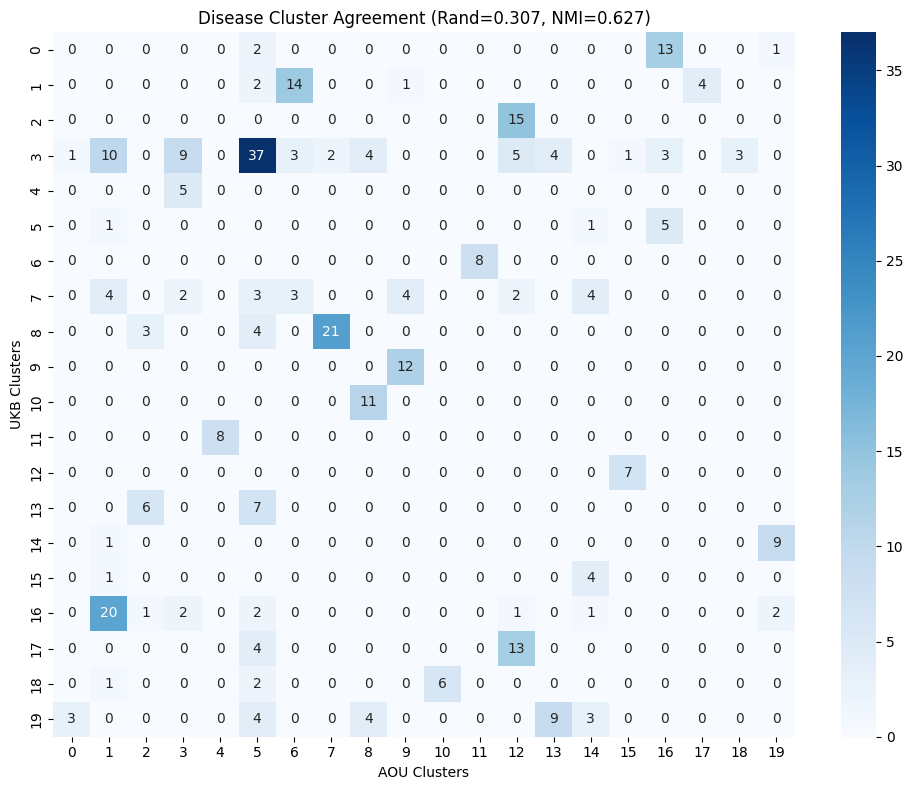

Overall agreement: 6.03%

Top consistently clustered diseases (21 total):
['Viral infection', 'Sleep disorders', 'Degenerative disease of the spinal cord', 'Otitis media', 'Acute upper respiratory infections of multiple or unspecified sites', 'Acute pharyngitis', 'Diseases of the larynx and vocal cords', 'Chronic tonsillitis and adenoiditis', 'Allergic rhinitis', 'Diseases of the oral soft tissues, excluding lesions specific for gingiva and tongue']

Top inconsistently clustered diseases (327 total):
['Bacterial enteritis', 'Viral Enteritis', 'Gram negative septicemia', 'Bacterial infection NOS', 'Staphylococcus infections', 'Streptococcus infection', 'E. coli', 'Viral warts & HPV', 'Candidiasis', 'Colon cancer']


(array([[ 0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         13,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  2, 14,  0,  0,  1,  0,  0,  0,  0,  0,  0,
          0,  4,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0,
          0,  0,  0,  0],
        [ 1, 10,  0,  9,  0, 37,  3,  2,  4,  0,  0,  0,  5,  4,  0,  1,
          3,  0,  3,  0],
        [ 0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
          5,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 0,  4,  0,  2,  0,  3,  3,  0,  0,  4,  0,  0,  2,  0,  4,  0,
          0,  0,  0,  0],
        [ 0,  0,  3,  0,  0,  4,  0, 21,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 

In [98]:
compare_disease_clusters(ukb_clusters, aou_clusters, disease_names)

In [23]:
aou_clusters[112:115]

array([16, 16, 16], dtype=int32)

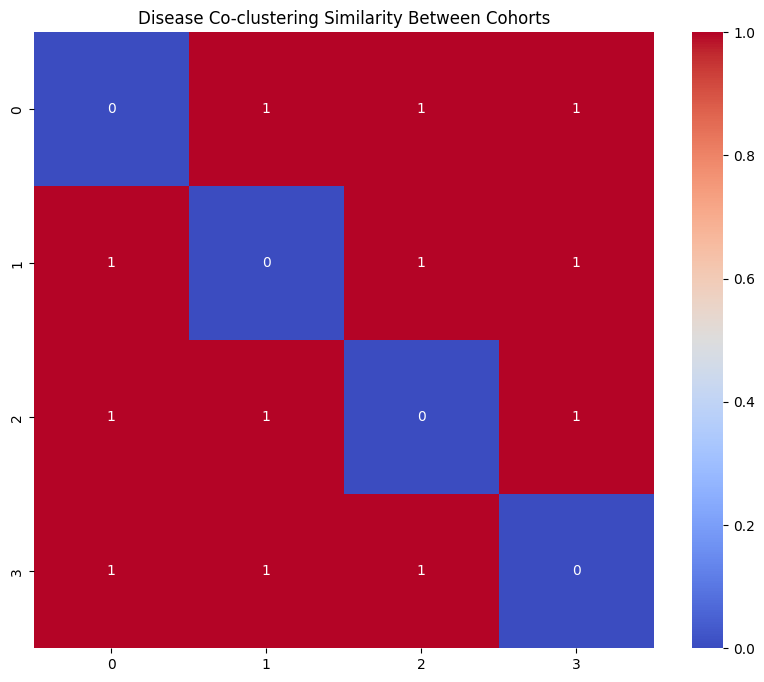

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_disease_groupings(aou_clusters, ukb_clusters, disease_indices):
    """
    Compare which diseases tend to cluster together across cohorts
    
    Args:
        aou_clusters: array where each element is cluster assignment for disease at that index
        ukb_clusters: array where each element is cluster assignment for disease at that index
        disease_indices: list of disease indices to compare
    """
    # For each disease pair, check if they're in same cluster in both cohorts
    n_diseases = len(disease_indices)
    co_clustering_similarity = np.zeros((n_diseases, n_diseases))
    
    for i in range(n_diseases):
        for j in range(i+1, n_diseases):
            # Check if pair clusters together in AOU
            aou_together = (aou_clusters[disease_indices[i]] == aou_clusters[disease_indices[j]])
            # Check if pair clusters together in UKB
            ukb_together = (ukb_clusters[disease_indices[i]] == ukb_clusters[disease_indices[j]])
            # 1 if they cluster similarly in both cohorts, 0 if different
            co_clustering_similarity[i,j] = aou_together == ukb_together
            co_clustering_similarity[j,i] = co_clustering_similarity[i,j]
    
    return co_clustering_similarity

# Example usage
disease_indices = range(112, 116)  # or whatever range you want to compare
similarity = compare_disease_groupings(aou_clusters, ukb_clusters, disease_indices)

# Visualize
plt.figure(figsize=(10,8))
sns.heatmap(similarity, annot=True, cmap='coolwarm')
plt.title('Disease Co-clustering Similarity Between Cohorts')
plt.show()

In [ ]:
torch.loadi('/Users/sarahurbut/aladynoulli2/pyScripts/oldstuff/printingaou.ipynb')